In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize, ManualInterval, AsinhStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
i1 = 7436
i2 = 7565
# why this sometimes takes so long 
# find which ones are variable
df_single_ps1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i1)+'.parquet')
df_single_ps2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps = pd.concat([df_single_ps1, df_single_ps2], ignore_index=True)

df_single_ps1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i1)+'.parquet')
df_single_ps2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux], ignore_index=True)

#df_single_sso = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/sso_'+str(i)+'.parquet')
#df_single_gal = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i)+'.parquet')
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]


ra_min =215.60
ra_max = 216.40
dec_min = -12.90
dec_max = -12.15

# Apply the filter to the dataframe
tru_var_obj = df_single_ps_var[
    (df_single_ps_var['ra'] >= ra_min) & (df_single_ps_var['ra'] <= ra_max) &
    (df_single_ps_var['dec'] >= dec_min) & (df_single_ps_var['dec'] <= dec_max)]

In [3]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

In [4]:
def plotFlagImages(exp, flagList=['NO_DATA', 'DETECTED', 'DETECTED_NEGATIVE', 'STREAK']):
    fig = plt.figure(figsize=(24,8))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im

In [5]:
repo = 'embargo_or4'

instrument = 'LSSTComCamSim'
schema =  f'pp_ppdb_lsstcomcamsim_or4'

butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
# skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [6]:
ra_min = 215.6
ra_max = 216.4
dec_min = -12.9
dec_max = -12.15

ra_min_in_rad = (ra_min*u.deg).to(u.rad).value
ra_max_in_rad = (ra_max*u.deg).to(u.rad).value
dec_min_in_rad = (dec_min*u.deg).to(u.rad).value
dec_max_in_rad = (dec_max*u.deg).to(u.rad).value


In [7]:
with apdbQuery.connection as connection:
    src4_field = pd.read_sql_query(f'''
        SELECT 
            "diaSourceId", 
            "diaObjectId", 
            "ra", 
            "dec", 
            "raErr", 
            "decErr", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "snr", 
            "band", 
            "visit",
            "detector",	
            "x",
            "xErr",
            "y",
            "yErr",
            "time_processed", 
            "time_withdrawn",
            "isDipole",
            "centroid_flag",
            "apFlux_flag",
            "apFlux_flag_apertureTruncated",
            "psfFlux_flag",
            "psfFlux_flag_edge",
            "psfFlux_flag_noGoodPixels",
            "trail_flag_edge",
            "forced_PsfFlux_flag",
            "forced_PsfFlux_flag_edge",
            "forced_PsfFlux_flag_noGoodPixels",
            "shape_flag",
            "shape_flag_no_pixels",
            "shape_flag_not_contained",
            "shape_flag_parent_source",
            "pixelFlags",
            "pixelFlags_bad",
            "pixelFlags_cr",
            "pixelFlags_crCenter",
            "pixelFlags_edge",
            "pixelFlags_interpolated",
            "pixelFlags_interpolatedCenter",
            "pixelFlags_offimage",
            "pixelFlags_saturated",
            "pixelFlags_saturatedCenter",
            "pixelFlags_suspect",
            "pixelFlags_suspectCenter",
            "pixelFlags_streak",
            "pixelFlags_streakCenter",
            "pixelFlags_injected",
            "pixelFlags_injectedCenter",
            "pixelFlags_injected_template",
            "pixelFlags_injected_templateCenter",
            "reliability"
        FROM "{schema}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [8]:
with apdbQuery.connection as connection:
    srcForced4_field = pd.read_sql_query(f'''
        SELECT 
            "diaForcedSourceId", 
            "diaObjectId", 
            "ra", 
            "dec",
            "visit",
            "detector", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "band"
        FROM "{schema}"."DiaForcedSource"
        WHERE "ra" BETWEEN {ra_min_in_rad} AND {ra_max_in_rad}
        AND "dec" BETWEEN {dec_min_in_rad} AND {dec_max_in_rad}
        LIMIT 3000000;
    ''', connection)
    
srcForced4_field['ra'] = radians_to_degrees(srcForced4_field['ra'].values)
srcForced4_field['dec'] = radians_to_degrees(srcForced4_field['dec'].values)

In [9]:
#latest = False does not work
or4_obj = apdbQuery.load_objects(limit=1e7, latest=True)

# We got all of them, less than 1e7 here
assert len(or4_obj) < 1e7

In [10]:
# lets look at only one field
# objects
obj4_field = or4_obj[(or4_obj['ra'] > ra_min) & (or4_obj['ra'] < ra_max) & (or4_obj['dec'] > dec_min) & (or4_obj['dec'] < dec_max)]
obj4_field

diaObjectId             validityStart validityEnd          ra  \
153210  3068394109505896606 2024-06-26 02:48:25+00:00        None  215.889039   
153235  3068394109505896635 2024-06-26 02:52:34+00:00        None  215.948394   
153238  3068394109505896638 2024-06-26 02:54:17+00:00        None  215.922383   
153239  3068394109505896639 2024-06-26 02:58:21+00:00        None  215.966875   
153244  3068394109505896644 2024-06-26 02:50:38+00:00        None  215.937075   
...                     ...                       ...         ...         ...   
171475  3068394172890218525 2024-06-26 02:55:53+00:00        None  215.635087   
171477  3068394172890218554 2024-06-26 02:55:53+00:00        None  215.690908   
171478  3068394172890218581 2024-06-26 02:55:53+00:00        None  215.665284   
171479  3068394172890218585 2024-06-26 02:55:53+00:00        None  215.677023   
171481  3068394172890218629 2024-06-26 02:55:53+00:00        None  215.749328   

               raErr        dec        decErr    ra_dec_Cov   radecMjdTai  \
153210           NaN -12.896901           NaN           NaN  60487.114560   
153235  2.019397e-05 -12.894802  9.924860e-06 -1.183491e-10  60487.117363   
153238  5.851012e-07 -12.885339  6.303400e-07  1.301129e-14  60487.118303   
153239  8.505353e-06 -12.899532  1.858597e-05  9.602694e-11  60487.118303   
153244           NaN -12.884774           NaN           NaN  60487.115963   
...              ...        ...           ...           ...           ...   
171475           NaN -12.360875           NaN           NaN  60487.119709   
171477  3.625022e-05 -12.306796  2.220503e-05  4.035649e-11  60487.119709   
171478  2.192825e-05 -12.264642  4.064201e-05 -5.401110e-11  60487.119709   
171479  2.335178e-05 -12.260069  2.930849e-05 -1.390424e-11  60487.119709   
171481           NaN -12.203916           NaN           NaN  60487.119709   

        pmRa  ... y_psfFluxPercentile95 y_psfFluxMin y_psfFluxMax  \
153210  None  ...                  None         None         None   
153235  None  ...                  None         None         None   
153238  None  ...                  None         None         None   
153239  None  ...                  None         None         None   
153244  None  ...                  None         None         None   
...      ...  ...                   ...          ...          ...   
171475  None  ...                  None         None         None   
171477  None  ...                  None         None         None   
171478  None  ...                  None         None         None   
171479  None  ...                  None         None         None   
171481  None  ...                  None         None         None   

       y_psfFluxStetsonJ y_psfFluxLinearSlope y_psfFluxLinearIntercept  \
153210              None                 None                     None   
153235              None                 None                     None   
153238              None                 None                     None   
153239              None                 None                     None   
153244              None                 None                     None   
...                  ...                  ...                      ...   
171475              None                 None                     None   
171477              None                 None                     None   
171478              None                 None                     None   
171479              None                 None                     None   
171481              None                 None                     None   

       y_psfFluxMaxSlope y_psfFluxErrMean       lastNonForcedSource  \
153210              None             None 2024-06-26 02:26:12+00:00   
153235              None             None 2024-06-26 02:51:18+00:00   
153238              None             None 2024-06-26 02:52:34+00:00   
153239              None             None 2024-06-26 02:52:34+00:00   
153244              None             None 202

# DM-46162

In [11]:
# find all object with more than 10 observations in a single band and all positive or negative detections 

def filter_diaObjectId_band_with_more_than_10(df):
    # Group by 'diaObjectId' and 'band' and filter those groups where the size is greater than 10
    filtered_df = df.groupby(['diaObjectId', 'band']).filter(lambda x: len(x) > 10)
    
    return filtered_df


src4_field_filtered = filter_diaObjectId_band_with_more_than_10(src4_field)


In [12]:
src4_field_filtered

diaSourceId          diaObjectId          ra        dec  \
68     3068394109518479361  3068394109518479361  216.012888 -12.755748   
75     3068394109518479368  3068394109518479368  216.113460 -12.781377   
79     3068394109518479372  3068394109518479372  216.004860 -12.740649   
82     3068394109518479375  3068394109518479375  216.105089 -12.767719   
83     3068394109518479376  3068394109518479376  216.109925 -12.767973   
...                    ...                  ...         ...        ...   
58130  3068394109505896788  3068394109505896788  215.967316 -12.767911   
58132  3068394109505896790  3068394109505896790  215.994768 -12.776436   
58239  3068394109510091035  3068394109510091035  215.911648 -12.748655   
58242  3068394109510091039  3068394109510091039  215.922683 -12.749456   
58244  3068394109510091041  3068394109510091041  215.706887 -12.680640   

              raErr        decErr  midpointMjdTai        psfFlux  psfFluxErr  \
68     7.717373e-07  6.583102e-07     60487.08931  215345.843750  590.044800   
75     1.579066e-05  1.497756e-05     60487.08931    2559.993408  461.119598   
79     2.050246e-05  1.749211e-05     60487.08931    1882.015381  214.087814   
82              NaN           NaN     60487.08931   -7166.795898  242.015366   
83              NaN           NaN     60487.08931   -3258.467529  216.219070   
...             ...           ...             ...            ...         ...   
58130  1.682332e-06  1.691311e-06     60487.08931   22557.074219  262.725861   
58132  1.426155e-05  1.188662e-05     60487.08931    2778.997070  237.556183   
58239  5.550080e-07  5.792799e-07     60487.08931  114288.781250  469.345490   
58242  1.703984e-07  1.732469e-07     60487.08931  692297.312500  891.888367   
58244  4.383545e-07  4.478728e-07     60487.08931  244720.875000  789.482361   

         scienceFlux  ...  pixelFlags_saturatedCenter  pixelFlags_suspect  \
68     306407.718750  ...                       False               False   
75     185663.296875  ...                       False               False   
79       1867.964722  ...                       False               False   
82      13968.073242  ...                       False               False   
83       1287.617554  ...                       False               False   
...              ...  ...                         ...                 ...   
58130   22763.609375  ...                       False               False   
58132    8815.101562  ...                       False               False   
58239  174976.968750  ...                       False               False   
58242  693754.687500  ...                       False               False   
58244  555998.875000  ...                       False               False   

      pixelFlags_suspectCenter  pixelFlags_streak  pixelFlags_streakCenter  \
68                       False              False                    False   
75                       False              False                    False   
79                       False              False                    False   
82                       False              False                    False   
83                       False              False                    False   
...                        ...                ...                      ...   
58130                    False              False                    False   
58132                    False              False                    False   
58239                    False              False                    False   
58242                    False              False                    False   
58244                    False              False                    False   

       pixelFlags_injected  pixelFlags_injectedCenter  \
68                   False                      False   
75                   False                      False   
79                   False                      False   
82                   False                      False   
83                

In [13]:
src4_field[src4_field['diaObjectId'] == 3068394109505896450]

Empty DataFrame
Columns: [diaSourceId, diaObjectId, ra, dec, raErr, decErr, midpointMjdTai, psfFlux, psfFluxErr, scienceFlux, scienceFluxErr, snr, band, visit, detector, x, xErr, y, yErr, time_processed, time_withdrawn, isDipole, centroid_flag, apFlux_flag, apFlux_flag_apertureTruncated, psfFlux_flag, psfFlux_flag_edge, psfFlux_flag_noGoodPixels, trail_flag_edge, forced_PsfFlux_flag, forced_PsfFlux_flag_edge, forced_PsfFlux_flag_noGoodPixels, shape_flag, shape_flag_no_pixels, shape_flag_not_contained, shape_flag_parent_source, pixelFlags, pixelFlags_bad, pixelFlags_cr, pixelFlags_crCenter, pixelFlags_edge, pixelFlags_interpolated, pixelFlags_interpolatedCenter, pixelFlags_offimage, pixelFlags_saturated, pixelFlags_saturatedCenter, pixelFlags_suspect, pixelFlags_suspectCenter, pixelFlags_streak, pixelFlags_streakCenter, pixelFlags_injected, pixelFlags_injectedCenter, pixelFlags_injected_template, pixelFlags_injected_templateCenter, reliability]
Index: []

[0 rows x 55 columns]

In [14]:
band_counts = src4_field.groupby(['diaObjectId', 'band']).size().unstack(fill_value=0).astype(int)
# Rename the columns in band_counts
band_counts_renamed = band_counts.rename(columns={
    'g': 'nDiaSources_g',
    'r': 'nDiaSources_r',
    'i': 'nDiaSources_i'
})
# Merge obj4_field with band_counts on diaObjectId
obj4_field_with_band_counts = pd.merge(obj4_field, band_counts_renamed, on='diaObjectId', how='left')

# If needed, fill NaN values with 0 (in case some diaObjectId in obj4_field doesn't exist in band_counts)
obj4_field_with_band_counts = obj4_field_with_band_counts.fillna(0)

In [15]:
obj4_many_g = obj4_field_with_band_counts[obj4_field_with_band_counts['nDiaSources_g'] > 10]

frac_pos = []
for i in range(len(obj4_many_g)):
    psf_flux_values = src4_field[src4_field['diaObjectId'] == obj4_many_g['diaObjectId'].values[i]]['psfFlux'].values
    frac_pos.append([int(i),np.sum(psf_flux_values>0)/len(psf_flux_values)])

frac_pos = np.array(frac_pos)

frac_pos[25]

array([25.,  0.])

In [16]:
obj4_many_i = obj4_field_with_band_counts[obj4_field_with_band_counts['nDiaSources_i'] > 10]
"""
for i in range(len(obj4_many_g)):
    psf_flux_values = src4_field[src4_field['diaObjectId'] == obj4_many_g['diaObjectId'].values[i]]['psfFlux'].values
    print([obj4_many_g['diaObjectId'].values[i],len(psf_flux_values>0)/len(psf_flux_values)])
"""

for i in range(20):
    psf_flux_values = src4_field[src4_field['diaObjectId'] == obj4_many_i['diaObjectId'].values[i]]['psfFlux'].values
    print([obj4_many_i['diaObjectId'].values[i],np.sum(psf_flux_values>0)/len(psf_flux_values)])

[3068394109505896788, 1.0]
[3068394109505896790, 1.0]
[3068394109510091026, 1.0]
[3068394109510091035, 1.0]
[3068394109510091039, 1.0]
[3068394109510091041, 0.8064516129032258]
[3068394109510091051, 1.0]
[3068394109510091052, 1.0]
[3068394109510091055, 1.0]
[3068394109518479361, 1.0]
[3068394109518479368, 0.8095238095238095]
[3068394109518479372, 1.0]
[3068394109518479375, 0.0]
[3068394109518479376, 0.0]
[3068394109518479377, 1.0]
[3068394109518479379, 1.0]
[3068394109518479382, 0.6666666666666666]
[3068394109518479383, 1.0]
[3068394109518479387, 0.0]
[3068394109518479390, 0.38095238095238093]


In [17]:
psf_flux_values = src4_field[src4_field['diaObjectId'] == 3068394109505896720]['psfFlux'].values
psf_flux_values = src4_field[src4_field['diaObjectId'] == 3068394109505896720]['psfFlux'].values


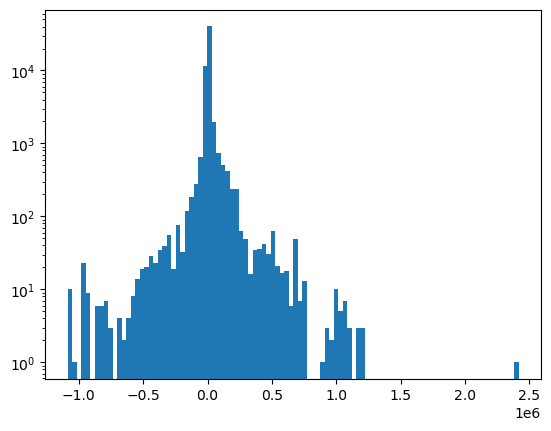

In [18]:
plt.hist(src4_field['psfFlux'].values, bins=100, log=True);

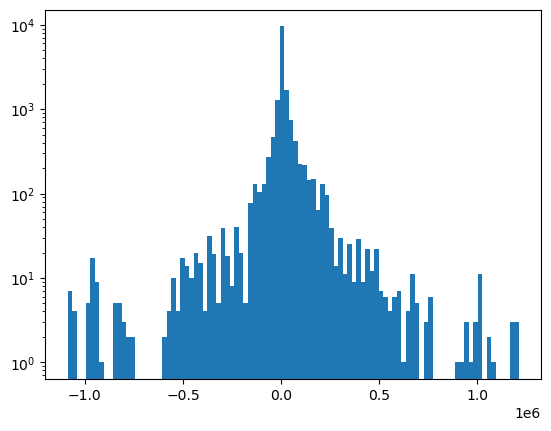

In [19]:
filtered_df = src4_field[src4_field['diaObjectId'].isin(obj4_many_g['diaObjectId'])]

plt.hist(filtered_df['psfFlux'].values, bins=100, log=True);

In [20]:
psfFlux = src4_field[src4_field['diaObjectId']==3068394109505896788]['psfFlux']
band = src4_field[src4_field['diaObjectId']==3068394109505896788]['band']
np.sum(psfFlux>0)/len(psfFlux)

1.0

In [21]:
min_mjd = src4_field['midpointMjdTai'].min()

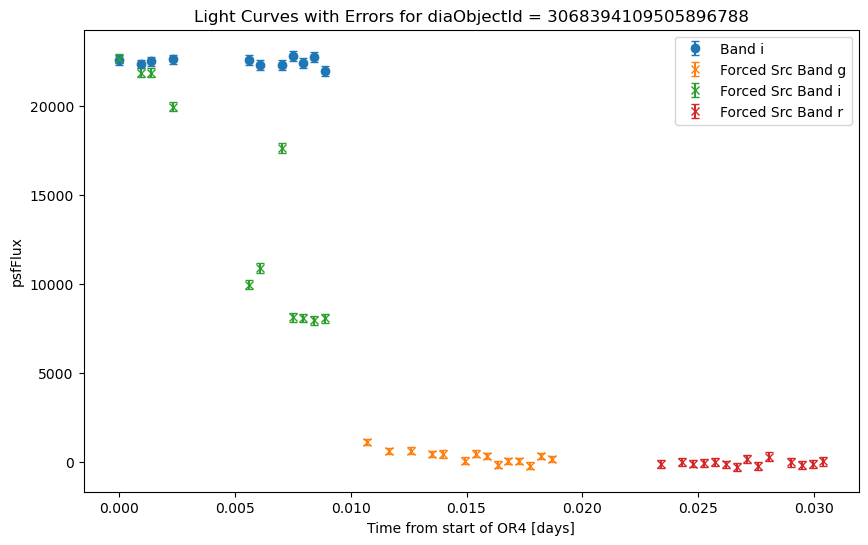

In [22]:
diaObjectId = 3068394109505896788

# Filter the data for the specific diaObjectId
mjd = src4_field[src4_field['diaObjectId'] == diaObjectId]['midpointMjdTai']
psfFlux = src4_field[src4_field['diaObjectId'] == diaObjectId]['psfFlux']
psfFluxErr = src4_field[src4_field['diaObjectId'] == diaObjectId]['psfFluxErr']
band = src4_field[src4_field['diaObjectId'] == diaObjectId]['band']

# Filter the data for the specific diaObjectId
mjdForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['midpointMjdTai']
psfFluxForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['psfFlux']
psfFluxErrForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['psfFluxErr']
bandForced = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId]['band']

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Get unique bands
unique_bands = band.unique()
unique_bandsForced = bandForced.unique()

# Plot each band with a different color and error bars
for b in unique_bands:
    band_mask = band == b
    plt.errorbar(mjd[band_mask] - min_mjd, psfFlux[band_mask], yerr=psfFluxErr[band_mask],
                 label=f'Band {b}', fmt='o', capsize=3)

# Plot each band with a different color and error bars
for b in unique_bandsForced:
    band_mask_forced = bandForced == b
    plt.errorbar(mjdForced[band_mask_forced] - min_mjd, psfFluxForced[band_mask_forced], yerr=psfFluxErrForced[band_mask_forced],
                 label=f'Forced Src Band {b}', fmt='x', capsize=3)

# Add labels and title
plt.xlabel('Time from start of OR4 [days]')
plt.ylabel('psfFlux')
plt.title('Light Curves with Errors for diaObjectId = 3068394109505896788')
plt.legend()

# Show the plot
plt.show()

In [23]:
nv_collections = ['LSSTComCamSim/runs/nightlyValidation/20240625/w_2024_25/DM-44966',
                  'LSSTComCamSim/runs/nightlyValidation/20240626/w_2024_25/DM-44966',
                  'LSSTComCamSim/runs/nightlyValidation/20240627/w_2024_25/DM-44966']
drp_collections = 'LSSTComCamSim/runs/DRP/OR4/w_2024_25/DM-45066'
pp_collections = ['LSSTComCamSim/prompt/output-2024-06-25',
                  'LSSTComCamSim/prompt/output-2024-06-26',
                  'LSSTComCamSim/prompt/output-2024-06-27']
pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)


In [24]:
repo

'embargo_or4'

In [25]:
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, MinMaxInterval, LogStretch

# example of source that is always there
single_src = src4_field[src4_field['diaObjectId'] == diaObjectId].iloc[0]
# single_src = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId].iloc[25]

visit_id = single_src['visit']

# visit_id = 7024062500249
detector_id = single_src['detector']
print(visit_id, detector_id, single_src['band'])

one_pp_diaSrcTable = pp_butler.get('goodSeeingDiff_diaSrcTable', dataId={'detector': detector_id, 'visit': visit_id})
one_pp_diffim = pp_butler.get('goodSeeingDiff_differenceExp', dataId={'detector': detector_id, 'visit': visit_id})

one_pp_science = pp_butler.get('initial_pvi', dataId={'detector': detector_id, 'visit': visit_id})
one_pp_template = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': detector_id, 'visit': visit_id})


7024062500192 1 i


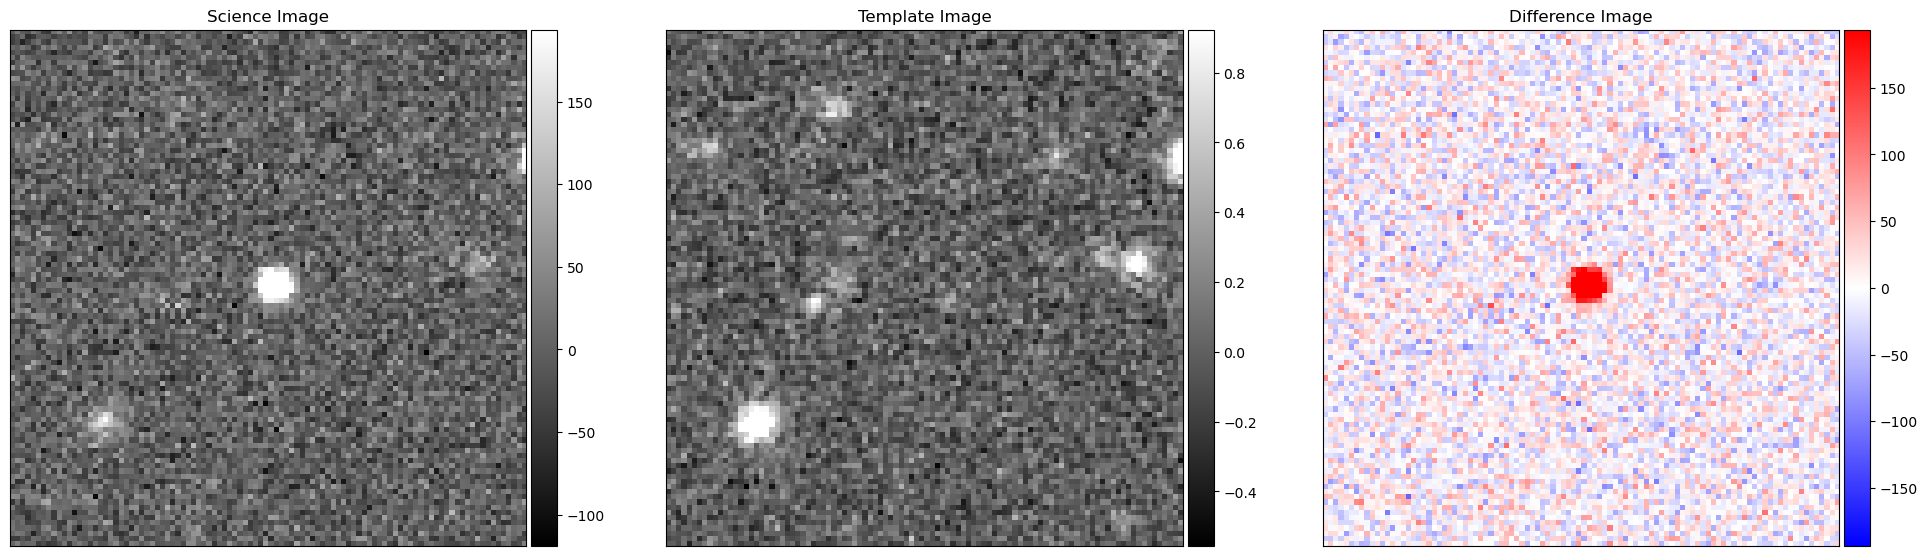

In [26]:

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))

# Define the region of interest
x_center = int(single_src['y'])
y_center = int(single_src['x'])
x_range = 50
y_range = 50

# Slice the region of interest
science_image = one_pp_science.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range]
template_image = one_pp_template.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range]
diffim_image = one_pp_diffim.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range]

# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_image, interval=ZScaleInterval())
norm_template = ImageNormalize(template_image, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)

# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(one_pp_science.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range], origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(one_pp_template.image.array[x_center-x_range+20:x_center+x_range+20, y_center-y_range+20:y_center+y_range+20], origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(one_pp_diffim.image.array[x_center-x_range:x_center+x_range, y_center-y_range:y_center+y_range], origin='lower', norm=norm_diffim, cmap='bwr')

# Plot scatter points on ax3
# ax3.scatter(one_pp_diaSrcTable.x, one_pp_diaSrcTable.y, alpha=0.5, s=2)

# Set axis limits for ax3 to zoom into the region of interest
#ax3.set_xlim([x_center - x_range, x_center + x_range])
# ax3.set_ylim([y_center - y_range, y_center + y_range])

# Hide the axis ticks for all subplots
for ax in [ax1, ax2, ax3]:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')

# Show the plot
plt.show()

# example of an image of all positive source

In [27]:
# lets try to get template images for this one particular source

single_src_Forced_g = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId].iloc[0]
print(single_src_Forced_g['diaObjectId'], single_src_Forced_g['ra'], single_src_Forced_g['dec'], single_src_Forced_g['band'], single_src_Forced_g['visit'])
one_pp_template_g = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': single_src_Forced_g['detector'], 'visit': single_src_Forced_g['visit']})

single_src_Forced_r = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId].iloc[37]
print(single_src_Forced_r['diaObjectId'], single_src_Forced_r['ra'], single_src_Forced_r['dec'], single_src_Forced_r['band'], single_src_Forced_r['visit'])
one_pp_template_r = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': single_src_Forced_r['detector'], 'visit': single_src_Forced_r['visit']})

single_src_Forced_i = srcForced4_field[srcForced4_field['diaObjectId'] == diaObjectId].iloc[25]
print(single_src_Forced_i['diaObjectId'], single_src_Forced_i['ra'], single_src_Forced_i['dec'], single_src_Forced_i['band'], single_src_Forced_i['visit'])
one_pp_template_i = pp_butler.get('goodSeeingDiff_templateExp', dataId={'detector': single_src_Forced_i['detector'], 'visit': single_src_Forced_i['visit']})



3068394109505896788 215.96755318185288 -12.768034846536322 g 7024062500214
3068394109505896788 215.96755318185288 -12.768034846536322 r 7024062500239
3068394109505896788 215.96755318185288 -12.768034846536322 r 7024062500241


In [28]:
obj4_field[obj4_field['diaObjectId'] == 3068394109505896788]

diaObjectId             validityStart validityEnd          ra  \
153375  3068394109505896788 2024-06-26 02:26:12+00:00        None  215.967553   

           raErr        dec    decErr    ra_dec_Cov   radecMjdTai  pmRa  ...  \
153375  0.000002 -12.768035  0.000002 -4.219479e-14  60487.098207  None  ...   

       y_psfFluxPercentile95 y_psfFluxMin y_psfFluxMax y_psfFluxStetsonJ  \
153375                  None         None         None              None   

       y_psfFluxLinearSlope y_psfFluxLinearIntercept y_psfFluxMaxSlope  \
153375                 None                     None              None   

       y_psfFluxErrMean       lastNonForcedSource nDiaSources  
153375             None 2024-06-26 02:24:30+00:00          11  

[1 rows x 190 columns]

In [29]:
srcForced4_field[srcForced4_field['diaObjectId'] == 3068394109505896788]

diaForcedSourceId          diaObjectId          ra        dec  \
20915   3068394135288283148  3068394109505896788  215.967553 -12.768035   
20916   3068394137427378211  3068394109505896788  215.967553 -12.768035   
20917   3068394138496925756  3068394109505896788  215.967553 -12.768035   
20918   3068394140661186578  3068394109505896788  215.967553 -12.768035   
20919   3068394141722345536  3068394109505896788  215.967553 -12.768035   
20920   3068394142796087351  3068394109505896788  215.967553 -12.768035   
20921   3068394143865634836  3068394109505896788  215.967553 -12.768035   
20922   3068394144943571106  3068394109505896788  215.967553 -12.768035   
20923   3068394146017312849  3068394109505896788  215.967553 -12.768035   
20924   3068394147086860387  3068394109505896788  215.967553 -12.768035   
20925   3068394148164796483  3068394109505896788  215.967553 -12.768035   
20926   3068394149238538249  3068394109505896788  215.967553 -12.768035   
46212   3068394109505896762  3068394109505896788  215.967316 -12.767911   
46213   3068394111657574522  3068394109505896788  215.967337 -12.767926   
46214   3068394112731316384  3068394109505896788  215.967352 -12.767933   
46215   3068394114878800032  3068394109505896788  215.967371 -12.767942   
46216   3068394122390798572  3068394109505896788  215.967412 -12.767964   
58280   3068394123468734661  3068394109505896788  215.967443 -12.767980   
58281   3068394125616218362  3068394109505896788  215.967553 -12.768035   
58282   3068394126689960130  3068394109505896788  215.967475 -12.767995   
58283   3068394127763701957  3068394109505896788  215.967501 -12.768009   
58284   3068394128837443738  3068394109505896788  215.967524 -12.768020   
58285   3068394129906991293  3068394109505896788  215.967544 -12.768030   
58286   3068394130984927535  3068394109505896788  215.967553 -12.768035   
58287   3068394133132411029  3068394109505896788  215.967553 -12.768035   
130519  3068394164270923910  3068394109505896788  215.967553 -12.768035   
130520  3068394165344665761  3068394109505896788  215.967553 -12.768035   
130521  3068394166418407556  3068394109505896788  215.967553 -12.768035   
130522  3068394167496343647  3068394109505896788  215.967553 -12.768035   
130523  3068394169635438692  3068394109505896788  215.967553 -12.768035   
130524  3068394170709180422  3068394109505896788  215.967553 -12.768035   
130525  3068394171791310901  3068394109505896788  215.967553 -12.768035   
130526  3068394172860858422  3068394109505896788  215.967553 -12.768035   
203760  3068394156754731226  3068394109505896788  215.967553 -12.768035   
203761  3068394158902214749  3068394109505896788  215.967553 -12.768035   
203762  3068394159975956504  3068394109505896788  215.967553 -12.768035   
203763  3068394161062281217  3068394109505896788  215.967553 -12.768035   
203764  3068394162123440148  3068394109505896788  215.967553 -12.768035   
203765  3068394163197182045  3068394109505896788  215.967553 -12.768035   

                visit  detector  midpointMjdTai       psfFlux  psfFluxErr  \
20915   7024062500214         3    60487.101903    629.663757  193.316971   
20916   7024062500216         1    60487.102839    455.789368  188.757507   
20917   7024062500217         0    60487.103308    458.318146  206.119858   
20918   7024062500219         4    60487.104245     92.336075  193.369843   
20919   7024062500220         1    60487.104713    474.621887  188.617249   
20920   7024062500221         1    60487.105179    332.441345  175.339935   
20921   7024062500222         0    60487.105648   -139.532043  187.095093   
20922   7024062500223         1    60487.106118     70.730446  173.803040   
20923   7024062500224         1    60487.106585     68.937805  171.453278   
20924   7024062500225         0    60487.107054   -196.867844  188.089035   
20925   7024062500226         1    60487.107523    329.149780  176.383392   
20926   7024062500227         1    60487.107991    198.801605  172.603058   
46212   

In [30]:
close_tru_obj = tru_var_obj[(tru_var_obj['ra']<single_src_Forced_g['ra']+0.02) & (tru_var_obj['ra']>single_src_Forced_g['ra']-0.02) & (tru_var_obj['dec']<single_src_Forced_g['dec']+0.02) & (tru_var_obj['dec']>single_src_Forced_g['dec']-0.02)]

In [31]:
center = lsst.geom.SpherePoint(single_src_Forced_i['ra'], single_src_Forced_i['dec'], lsst.geom.degrees)
# center = lsst.geom.SpherePoint(close_tru_obj['ra'].values[0], close_tru_obj['dec'].values[0], lsst.geom.degrees)
s = 200
extent = lsst.geom.Extent2I(s, s)

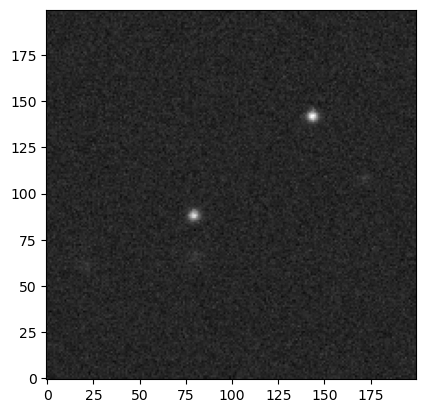

In [32]:
single_src_Forced_r = srcForced4_field[srcForced4_field['diaForcedSourceId'] == 3068394172860858422]
#nothing in r
one_pp_science_r = pp_butler.get('initial_pvi', dataId={'detector': single_src_Forced_r['detector'].values[0], 'visit': single_src_Forced_r['visit'].values[0]})

science_cutout = one_pp_science_r.getCutout(center, extent)
# template_cutout = template.getCutout(center, extent)
# difference_cutout = difference.getCutout(center, extent)

plt.imshow(science_cutout.image.array, origin='lower', cmap='gray')

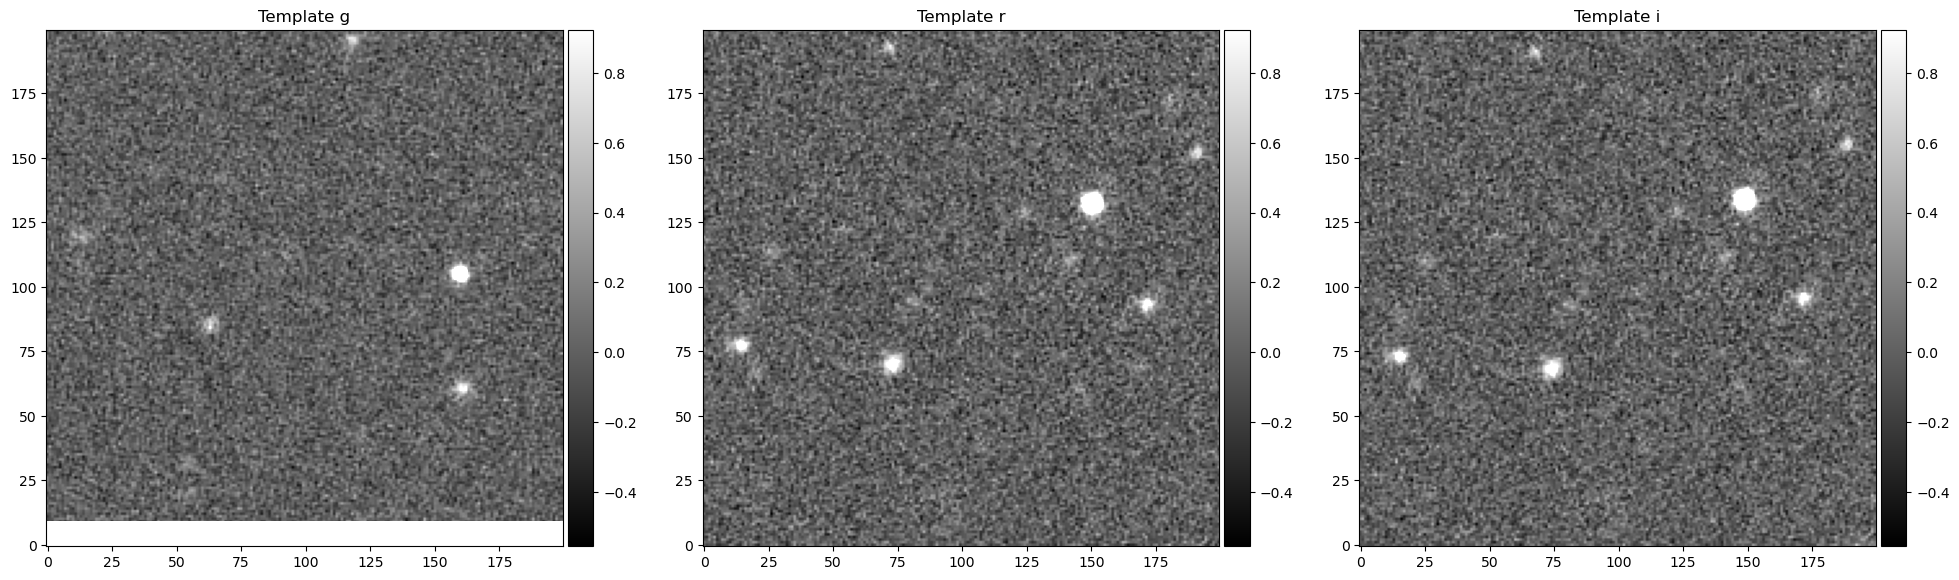

In [33]:
template_g_cutout = one_pp_template_g.getCutout(center, extent)
template_r_cutout = one_pp_template_r.getCutout(center, extent)
template_i_cutout = one_pp_template_i.getCutout(center, extent)

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(template_g_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')
img2 = ax2.imshow(template_r_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(template_i_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Template g')
ax2.set_title('Template r')
ax3.set_title('Template i')

# Show the plot
plt.show()



In [34]:
df_obj = obj4_field[obj4_field['diaObjectId'] == 3068394109505896788]
tru_obj = tru_var_obj
match_value = 1
# all of the diaObjects in a field
dia_obj_SC = SkyCoord(ra=df_obj['ra'].values*u.degree, dec=df_obj['dec'].values*u.degree) 
# all of the variable objects in a field
tru_obj_SC = SkyCoord(ra=tru_obj['ra'].values*u.degree, dec=tru_obj['dec'].values*u.degree)
# match the observations to the truth
idx, d2d, d3d = tru_obj_SC.match_to_catalog_sky(dia_obj_SC)
# index of all diaObj that are within match_value of a true variable object
idx_close = idx[d2d.to(u.arcsec).value<match_value]
print(np.min(d2d.to(u.arcsec).value))
# all of diaObjects thare are within match_value of a variable object
matches_close = df_obj.iloc[idx_close]
matches_close

50.60129401651837


Empty DataFrame
Columns: [diaObjectId, validityStart, validityEnd, ra, raErr, dec, decErr, ra_dec_Cov, radecMjdTai, pmRa, pmRaErr, pmDec, pmDecErr, parallax, parallaxErr, pmRa_pmDec_Cov, pmRa_parallax_Cov, pmDec_parallax_Cov, pmParallaxLnL, pmParallaxChi2, pmParallaxNdata, u_psfFluxMean, u_psfFluxMeanErr, u_psfFluxSigma, u_psfFluxChi2, u_psfFluxNdata, u_fpFluxMean, u_fpFluxMeanErr, u_fpFluxSigma, g_psfFluxMean, g_psfFluxMeanErr, g_psfFluxSigma, g_psfFluxChi2, g_psfFluxNdata, g_fpFluxMean, g_fpFluxMeanErr, g_fpFluxSigma, r_psfFluxMean, r_psfFluxMeanErr, r_psfFluxSigma, r_psfFluxChi2, r_psfFluxNdata, r_fpFluxMean, r_fpFluxMeanErr, r_fpFluxSigma, i_psfFluxMean, i_psfFluxMeanErr, i_psfFluxSigma, i_psfFluxChi2, i_psfFluxNdata, i_fpFluxMean, i_fpFluxMeanErr, i_fpFluxSigma, z_psfFluxMean, z_psfFluxMeanErr, z_psfFluxSigma, z_psfFluxChi2, z_psfFluxNdata, z_fpFluxMean, z_fpFluxMeanErr, z_fpFluxSigma, y_psfFluxMean, y_psfFluxMeanErr, y_psfFluxSigma, y_psfFluxChi2, y_psfFluxNdata, y_fpFluxMean, y_fpFluxMeanErr, y_fpFluxSigma, nearbyObj1, nearbyObj1Dist, nearbyObj1LnP, nearbyObj2, nearbyObj2Dist, nearbyObj2LnP, nearbyObj3, nearbyObj3Dist, nearbyObj3LnP, nearbyExtObj1, nearbyExtObj1Sep, nearbyExtObj2, nearbyExtObj2Sep, nearbyExtObj3, nearbyExtObj3Sep, nearbyLowzGal, nearbyLowzGalSep, u_scienceFluxMean, u_scienceFluxMeanErr, u_scienceFluxSigma, g_scienceFluxMean, g_scienceFluxMeanErr, g_scienceFluxSigma, r_scienceFluxMean, r_scienceFluxMeanErr, r_scienceFluxSigma, i_scienceFluxMean, i_scienceFluxMeanErr, i_scienceFluxSigma, z_scienceFluxMean, z_scienceFluxMeanErr, ...]
Index: []

[0 rows x 190 columns]

In [35]:
# Assuming d2d.to(u.arcsec).value is a numpy array
values = np.array(d2d.to(u.arcsec).value)

# Find the index of the minimum value
min_index = np.argmin(values)
tru_obj.iloc[min_index]


object_type                                               star
id                                                  1009899244
ra                                                  215.956136
dec                                                 -12.776613
host_galaxy_id                                               0
magnorm                                               21.39623
sed_filepath         starSED/kurucz/km20_5500.fits_g15_5560.gz
MW_rv                                                      3.1
MW_av                                                 0.272701
mura                                                     -1.36
mudec                                                    -3.07
radial_velocity                                         239.06
parallax                                              0.080427
variability_model                                             
salt2_params                                              None
is_variable                                            

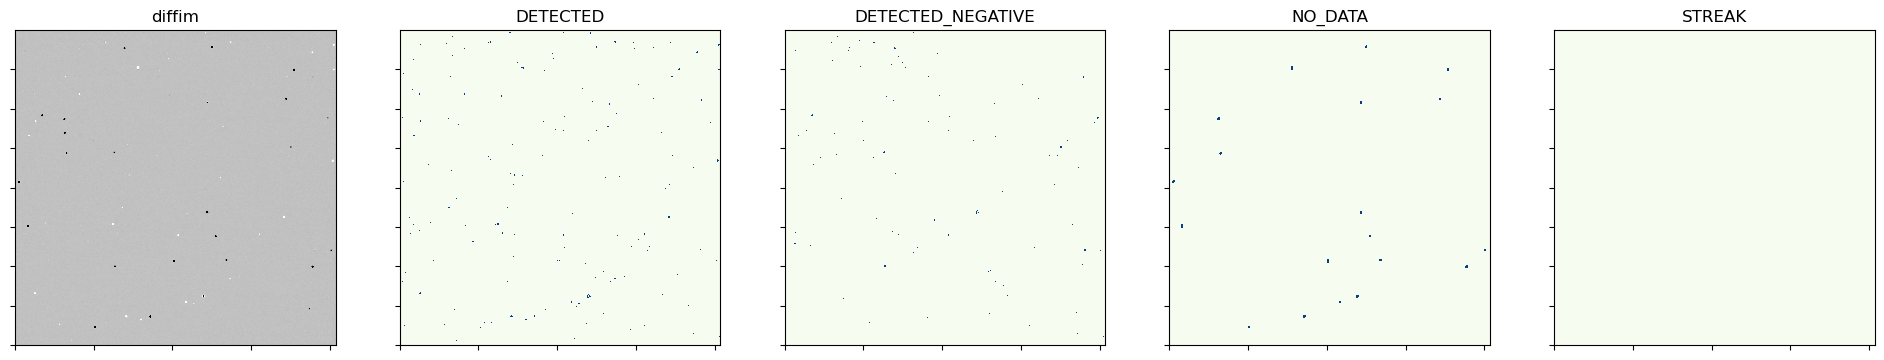

In [36]:
plotFlagImages(one_pp_diffim)


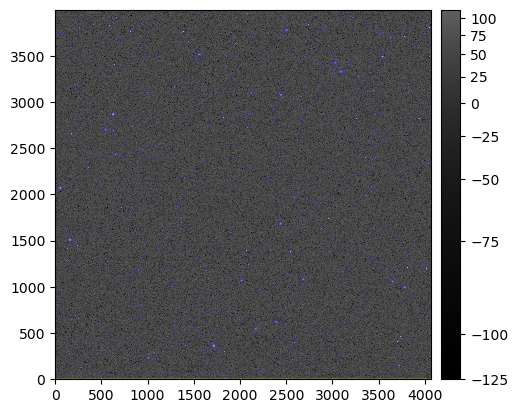

In [37]:
# Set up Jupyter to render matplotlib inline
%matplotlib inline

# Import necessary LSST modules
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage



# Initialize the display with matplotlib backend
disp = afwDisplay.Display(1, "matplotlib")
disp.scale("asinh", "zscale")
# Display the image in Jupyter
disp.mtv(one_pp_science)

In [38]:
obj4_more_10 = obj4_field_with_band_counts[
    (obj4_field_with_band_counts['nDiaSources_g'] > 10) | 
    (obj4_field_with_band_counts['nDiaSources_i'] > 10) | 
    (obj4_field_with_band_counts['nDiaSources_r'] > 10)
]
obj4_more_10 = obj4_more_10.copy(deep=True)
obj4_more_10

diaObjectId             validityStart  validityEnd          ra  \
44    3068394109505896706 2024-06-26 02:58:21+00:00            0  215.988803   
55    3068394109505896720 2024-06-26 02:58:21+00:00            0  216.011773   
57    3068394109505896722 2024-06-26 02:58:21+00:00            0  215.994210   
72    3068394109505896739 2024-06-26 02:58:21+00:00            0  215.986590   
73    3068394109505896740 2024-06-26 02:58:21+00:00            0  215.976909   
...                   ...                       ...          ...         ...   
8008  3068394156758925466 2024-06-26 02:56:33+00:00            0  215.980679   
8120  3068394157841055842 2024-06-26 02:55:40+00:00            0  215.979755   
8371  3068394159984345218 2024-06-26 02:55:37+00:00            0  216.101265   
8381  3068394159988539507 2024-06-26 02:56:33+00:00            0  215.985925   
8501  3068394161062281329 2024-06-26 02:55:16+00:00            0  216.023503   

             raErr        dec        decErr    ra_dec_Cov   radecMjdTai  pmRa  \
44    6.051799e-06 -12.846673  6.745328e-06  2.462018e-12  60487.119709     0   
55    2.798506e-06 -12.842626  2.892115e-06  3.922076e-14  60487.119709     0   
57    2.229718e-06 -12.836417  2.346040e-06  9.453771e-14  60487.119709     0   
72    1.213741e-06 -12.818173  1.229305e-06 -1.450207e-14  60487.119709     0   
73    5.093655e-06 -12.814752  5.430930e-06  7.737264e-13  60487.119709     0   
...            ...        ...           ...           ...           ...   ...   
8008  1.737560e-05 -12.557215  1.494686e-05 -2.479273e-11  60487.119709     0   
8120  2.396693e-07 -12.300577  2.437930e-07 -1.814534e-16  60487.119709     0   
8371  6.951838e-06 -12.435812  7.353275e-06  6.492552e-13  60487.119709     0   
8381  8.232452e-06 -12.448405  8.986657e-06  1.844188e-12  60487.119709     0   
8501  1.432216e-05 -12.637366  1.537307e-05  3.454342e-12  60487.119240     0   

      ...  y_psfFluxStetsonJ  y_psfFluxLinearSlope  y_psfFluxLinearIntercept  \
44    ...                  0                     0                         0   
55    ...                  0                     0                         0   
57    ...                  0                     0                         0   
72    ...                  0                     0                         0   
73    ...                  0                     0                         0   
...   ...                ...                   ...                       ...   
8008  ...                  0                     0                         0   
8120  ...                  0                     0                         0   
8371  ...                  0                     0                         0   
8381  ...                  0                     0                         0   
8501  ...                  0                     0                         0   

      y_psfFluxMaxSlope  y_psfFluxErrMean       lastNonForcedSource  \
44                    0                 0 2024-06-26 02:55:43+00:00   
55                    0                 0 2024-06-26 02:55:43+00:00   
57                    0                 0 2024-06-26 02:55:43+00:00   
72                    0                 0 2024-06-26 02:55:43+00:00   
73                    0                 0 2024-06-26 02:55:43+00:00   
...                 ...               ...                       ...   
8008                  0                 0 2024-06-26 02:55:11+00:00   
8120                  0                 0 2024-06-26 02:55:26+00:00   
8371                  0                 0 2024-06-26 02:55:26+00:00   
8381                  0                 0 2024-06-26 02:55:11+00:00   
8501                  0                 0 2024-06-26 02:54:41+00:00   

      nDiaSources  nDiaSources_g  nDiaSources_i  nDiaSources_r  
44             26             11              6              9  
55             31             12              7             12  
57             31             12              7             12  
72    

In [39]:
fractions_g = []
fractions_r = []
fractions_i = []

# Loop over each row in obj4_more_10
for index, row in obj4_more_10.iterrows():
    diaObjectId = row['diaObjectId']
    
    # For each band (g, r, i), filter the rows in src4_field that match the diaObjectId and the band
    for band, fractions_list in zip(['g', 'r', 'i'], [fractions_g, fractions_r, fractions_i]):
        # Get the matching rows for the current diaObjectId and band
        matching_rows = srcForced4_field[(srcForced4_field['diaObjectId'] == diaObjectId) & (srcForced4_field['band'] == band)]
        
        # Extract the psfFlux values for the matching rows
        psfFlux_values = matching_rows['psfFlux']
        
        # Calculate the fraction of psfFlux values greater than 0
        if len(psfFlux_values) > 0:
            fraction_positive = (psfFlux_values > 0).sum() / len(psfFlux_values)
        else:
            fraction_positive = np.nan  # Set to NaN if there are no observations in that band
        
        # Append the result to the corresponding fractions list
        fractions_list.append(fraction_positive)

# Add the fractions as new columns in obj4_more_10
# Now, safely assign the new columns using .loc to avoid the warning
obj4_more_10['fraction_positive_psfFlux_g'] = fractions_g
obj4_more_10['fraction_positive_psfFlux_r'] = fractions_r
obj4_more_10['fraction_positive_psfFlux_i'] = fractions_i

In [40]:
srcForced4_field

diaForcedSourceId          diaObjectId          ra        dec  \
0       3068394139604222223  3068394112760676368  215.880902 -12.369143   
1       3068394134201958667  3068394111653380297  216.167347 -12.659589   
2       3068394122403381586  3068394111653380299  216.096035 -12.638019   
3       3068394123477123361  3068394111653380299  216.096030 -12.638019   
4       3068394124542476619  3068394111653380299  216.096024 -12.638015   
...                     ...                  ...         ...        ...   
222053  3068394163192988382  3068394112727122057  216.204005 -12.870464   
222054  3068394154603053345  3068394112727122061  216.312315 -12.897215   
222055  3068394161045504451  3068394112727122061  216.312316 -12.897216   
222056  3068394154603053099  3068394112727122062  216.256485 -12.881426   
222057  3068394158898020828  3068394112727122062  216.256499 -12.881423   

                visit  detector  midpointMjdTai       psfFlux  psfFluxErr  \
0       7024062500218         8    60487.103777   -215.352280  293.418518   
1       7024062500213         0    60487.101433    690.625977  207.335358   
2       7024062500202         3    60487.094933   3906.299561  259.696259   
3       7024062500203         3    60487.095400   3945.080078  257.102051   
4       7024062500204         1    60487.095871   3746.103271  251.612152   
...               ...       ...             ...           ...         ...   
222053  7024062500240         0    60487.115497   2039.768677  222.082443   
222054  7024062500232         0    60487.111744  10167.688477  316.825134   
222055  7024062500238         0    60487.114560   8562.610352  287.237671   
222056  7024062500232         0    60487.111744   1330.667114  422.234924   
222057  7024062500236         0    60487.113623   3422.775146  402.191315   

          scienceFlux  scienceFluxErr band  
0       118478.304688      280.510254    g  
1        19150.101562      196.628754    g  
2         9614.225586      253.139328    i  
3         9846.491211      250.505386    i  
4         9699.782227      244.980042    i  
...               ...             ...  ...  
222053    3142.970459      205.965271    r  
222054   33572.269531      288.390839    r  
222055   32946.242188      261.588715    r  
222056  118827.078125      383.545654    r  
222057  117635.625000      376.297424    r  

[222058 rows x 12 columns]

In [41]:
obj4_more_10[obj4_more_10['fraction_positive_psfFlux_i']==0]

diaObjectId             validityStart  validityEnd          ra  \
74    3068394109505896741 2024-06-26 02:55:43+00:00            0  215.950486   
85    3068394109505896752 2024-06-26 02:58:21+00:00            0  216.042633   
87    3068394109505896754 2024-06-26 02:58:21+00:00            0  215.966077   
130   3068394109505896798 2024-06-26 02:58:21+00:00            0  216.105063   
132   3068394109505896800 2024-06-26 02:58:21+00:00            0  216.138309   
...                   ...                       ...          ...         ...   
3041  3068394112743899286 2024-06-26 02:55:03+00:00            0  216.002316   
3055  3068394112748093466 2024-06-26 02:55:36+00:00            0  215.742532   
3063  3068394112748093504 2024-06-26 02:55:36+00:00            0  215.757784   
3696  3068394114891382882 2024-06-26 02:56:33+00:00            0  215.973052   
5037  3068394129932157003 2024-06-26 02:55:40+00:00            0  215.930876   

      raErr        dec  decErr  ra_dec_Cov   radecMjdTai  pmRa  ...  \
74      0.0 -12.805079     0.0         0.0  60487.119709     0  ...   
85      0.0 -12.821659     0.0         0.0  60487.119709     0  ...   
87      0.0 -12.795307     0.0         0.0  60487.119709     0  ...   
130     0.0 -12.807640     0.0         0.0  60487.118303     0  ...   
132     0.0 -12.815000     0.0         0.0  60487.119709     0  ...   
...     ...        ...     ...         ...           ...   ...  ...   
3041    0.0 -12.508183     0.0         0.0  60487.118770     0  ...   
3055    0.0 -12.558555     0.0         0.0  60487.119709     0  ...   
3063    0.0 -12.522581     0.0         0.0  60487.119709     0  ...   
3696    0.0 -12.540759     0.0         0.0  60487.119709     0  ...   
5037    0.0 -12.325005     0.0         0.0  60487.119709     0  ...   

      y_psfFluxMaxSlope  y_psfFluxErrMean       lastNonForcedSource  \
74                    0                 0 2024-06-26 02:55:16+00:00   
85                    0                 0 2024-06-26 02:55:43+00:00   
87                    0                 0 2024-06-26 02:55:43+00:00   
130                   0                 0 2024-06-26 02:52:35+00:00   
132                   0                 0 2024-06-26 02:56:11+00:00   
...                 ...               ...                       ...   
3041                  0                 0 2024-06-26 02:52:52+00:00   
3055                  0                 0 2024-06-26 02:54:14+00:00   
3063                  0                 0 2024-06-26 02:55:14+00:00   
3696                  0                 0 2024-06-26 02:55:11+00:00   
5037                  0                 0 2024-06-26 02:55:26+00:00   

      nDiaSources  nDiaSources_g  nDiaSources_i  nDiaSources_r  \
74             31             14              7             10   
85             19              0              7             12   
87             34             12              9             13   
130            31             13              9              9   
132            34             12              9             13   
...           ...            ...            ...            ...   
3041           14              0              3             11   
3055           34             15              8             11   
3063           36             17              7             12   
3696           18              0              1             17   
5037           17              0              1             16   

      fraction_positive_psfFlux_g  fraction_positive_psfFlux_r  \
74                       0.000000                          0.0   
85                       0.384615                          0.0   
87                       0.000000                          0.0   
130                      0.000000                          0.0   
132                      0.000000                          0.0   
...                           ...                          ...   
3041                     0.733333                          0.0   
3055                     0

In [42]:
obj4_more_10

diaObjectId             validityStart  validityEnd          ra  \
44    3068394109505896706 2024-06-26 02:58:21+00:00            0  215.988803   
55    3068394109505896720 2024-06-26 02:58:21+00:00            0  216.011773   
57    3068394109505896722 2024-06-26 02:58:21+00:00            0  215.994210   
72    3068394109505896739 2024-06-26 02:58:21+00:00            0  215.986590   
73    3068394109505896740 2024-06-26 02:58:21+00:00            0  215.976909   
...                   ...                       ...          ...         ...   
8008  3068394156758925466 2024-06-26 02:56:33+00:00            0  215.980679   
8120  3068394157841055842 2024-06-26 02:55:40+00:00            0  215.979755   
8371  3068394159984345218 2024-06-26 02:55:37+00:00            0  216.101265   
8381  3068394159988539507 2024-06-26 02:56:33+00:00            0  215.985925   
8501  3068394161062281329 2024-06-26 02:55:16+00:00            0  216.023503   

             raErr        dec        decErr    ra_dec_Cov   radecMjdTai  pmRa  \
44    6.051799e-06 -12.846673  6.745328e-06  2.462018e-12  60487.119709     0   
55    2.798506e-06 -12.842626  2.892115e-06  3.922076e-14  60487.119709     0   
57    2.229718e-06 -12.836417  2.346040e-06  9.453771e-14  60487.119709     0   
72    1.213741e-06 -12.818173  1.229305e-06 -1.450207e-14  60487.119709     0   
73    5.093655e-06 -12.814752  5.430930e-06  7.737264e-13  60487.119709     0   
...            ...        ...           ...           ...           ...   ...   
8008  1.737560e-05 -12.557215  1.494686e-05 -2.479273e-11  60487.119709     0   
8120  2.396693e-07 -12.300577  2.437930e-07 -1.814534e-16  60487.119709     0   
8371  6.951838e-06 -12.435812  7.353275e-06  6.492552e-13  60487.119709     0   
8381  8.232452e-06 -12.448405  8.986657e-06  1.844188e-12  60487.119709     0   
8501  1.432216e-05 -12.637366  1.537307e-05  3.454342e-12  60487.119240     0   

      ...  y_psfFluxMaxSlope  y_psfFluxErrMean       lastNonForcedSource  \
44    ...                  0                 0 2024-06-26 02:55:43+00:00   
55    ...                  0                 0 2024-06-26 02:55:43+00:00   
57    ...                  0                 0 2024-06-26 02:55:43+00:00   
72    ...                  0                 0 2024-06-26 02:55:43+00:00   
73    ...                  0                 0 2024-06-26 02:55:43+00:00   
...   ...                ...               ...                       ...   
8008  ...                  0                 0 2024-06-26 02:55:11+00:00   
8120  ...                  0                 0 2024-06-26 02:55:26+00:00   
8371  ...                  0                 0 2024-06-26 02:55:26+00:00   
8381  ...                  0                 0 2024-06-26 02:55:11+00:00   
8501  ...                  0                 0 2024-06-26 02:54:41+00:00   

      nDiaSources  nDiaSources_g  nDiaSources_i  nDiaSources_r  \
44             26             11              6              9   
55             31             12              7             12   
57             31             12              7             12   
72             29             12              8              9   
73             34             14              8             12   
...           ...            ...            ...            ...   
8008           14              0              0             14   
8120           14              0              0             14   
8371           11              0              0             11   
8381           12              0              0             12   
8501           11              0              0             11   

      fraction_positive_psfFlux_g  fraction_positive_psfFlux_r  \
44                       0.916667                     1.000000   
55                       1.000000                     1.000000   
57                       1.000000                     1.000000   
72                       0.714286                     0.800000   
73                       1.000000           

Text(0, 0.5, 'decErr')

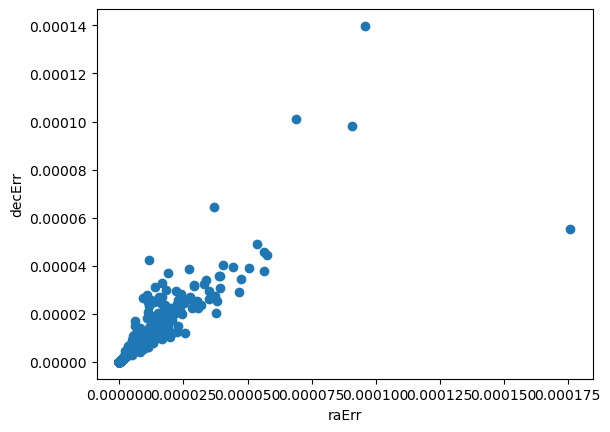

In [43]:
plt.scatter(obj4_more_10['raErr'],obj4_more_10['decErr'])
plt.xlabel('raErr')
plt.ylabel('decErr')



In [44]:
obj4_field_nan = obj4_field[pd.isna(obj4_field['raErr'])]
obj4_field_not_nan = obj4_field[pd.notna(obj4_field['raErr'])]

print(len(obj4_field_not_nan))
print(len(obj4_field_nan))

5876
4066


(array([7117., 1033.,  619.,  367.,  217.,  192.,  136.,  116.,  104.,
          41.]),
 array([ 1. ,  5.8, 10.6, 15.4, 20.2, 25. , 29.8, 34.6, 39.4, 44.2, 49. ]),
 <BarContainer object of 10 artists>)

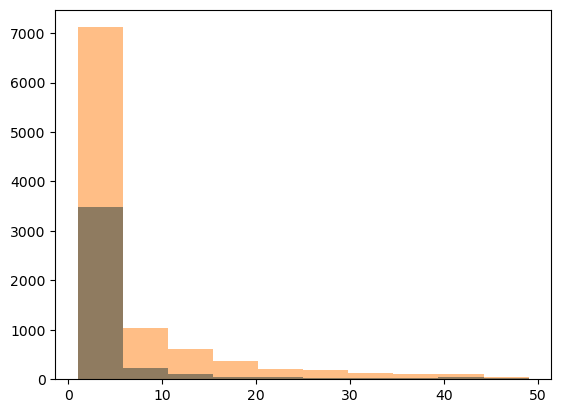

In [45]:
plt.hist(obj4_field_nan['nDiaSources'].values)
plt.hist(obj4_field['nDiaSources'].values, alpha=0.5)

In [46]:
obj4_field_nan[obj4_field_nan['nDiaSources']>20]

diaObjectId             validityStart validityEnd          ra  \
153285  3068394109505896692 2024-06-26 02:58:21+00:00        None  216.025599   
153306  3068394109505896715 2024-06-26 02:58:21+00:00        None  216.093117   
153329  3068394109505896741 2024-06-26 02:55:43+00:00        None  215.950486   
153342  3068394109505896754 2024-06-26 02:58:21+00:00        None  215.966077   
153385  3068394109505896798 2024-06-26 02:58:21+00:00        None  216.105063   
...                     ...                       ...         ...         ...   
158424  3068394122420158632 2024-06-26 02:55:40+00:00        None  215.806231   
161012  3068394130993315861 2024-06-26 02:58:21+00:00        None  216.164836   
161042  3068394130993315981 2024-06-26 02:55:46+00:00        None  216.261222   
161055  3068394130997510198 2024-06-26 02:55:43+00:00        None  216.041870   
161198  3068394131010093138 2024-06-26 02:55:37+00:00        None  216.206395   

        raErr        dec  decErr  ra_dec_Cov   radecMjdTai  pmRa  ...  \
153285    NaN -12.869148     NaN         NaN  60487.118303  None  ...   
153306    NaN -12.872509     NaN         NaN  60487.118303  None  ...   
153329    NaN -12.805079     NaN         NaN  60487.119709  None  ...   
153342    NaN -12.795307     NaN         NaN  60487.119709  None  ...   
153385    NaN -12.807640     NaN         NaN  60487.118303  None  ...   
...       ...        ...     ...         ...           ...   ...  ...   
158424    NaN -12.210653     NaN         NaN  60487.119709  None  ...   
161012    NaN -12.853839     NaN         NaN  60487.119709  None  ...   
161042    NaN -12.701542     NaN         NaN  60487.119240  None  ...   
161055    NaN -12.684175     NaN         NaN  60487.119709  None  ...   
161198    NaN -12.404008     NaN         NaN  60487.119709  None  ...   

       y_psfFluxPercentile95 y_psfFluxMin y_psfFluxMax y_psfFluxStetsonJ  \
153285                  None         None         None              None   
153306                  None         None         None              None   
153329                  None         None         None              None   
153342                  None         None         None              None   
153385                  None         None         None              None   
...                      ...          ...          ...               ...   
158424                  None         None         None              None   
161012                  None         None         None              None   
161042                  None         None         None              None   
161055                  None         None         None              None   
161198                  None         None         None              None   

       y_psfFluxLinearSlope y_psfFluxLinearIntercept y_psfFluxMaxSlope  \
153285                 None                     None              None   
153306                 None                     None              None   
153329                 None                     None              None   
153342                 None                     None              None   
153385                 None                     None              None   
...                     ...                      ...               ...   
158424                 None                     None              None   
161012                 None                     None              None   
161042                 None                     None              None   
161055                 None                     None              None   
161198                 None                     None              None   

       y_psfFluxErrMean       lastNonForcedSource nDiaSources  
153285             None 2024-06-26 02:52:34+00:00          25  
153306             None 2024-06-26 02:52:35+00:00          24  
153329             None 2024-06-26 02:55:16+00:00          31  
153342             None 2024-06-26 02:55:43+00:00          34  
153385             None 2024-06-26 02:52:35+

In [47]:
obj4_field_not_nan[obj4_field_not_nan['nDiaSources']>20]

diaObjectId             validityStart validityEnd          ra  \
153238  3068394109505896638 2024-06-26 02:54:17+00:00        None  215.922383   
153253  3068394109505896654 2024-06-26 02:55:43+00:00        None  215.906475   
153271  3068394109505896673 2024-06-26 02:58:21+00:00        None  215.971620   
153283  3068394109505896690 2024-06-26 02:58:21+00:00        None  216.069831   
153297  3068394109505896704 2024-06-26 02:58:21+00:00        None  216.023306   
...                     ...                       ...         ...         ...   
161223  3068394131014287474 2024-06-26 02:55:26+00:00        None  216.026949   
161402  3068394133136605278 2024-06-26 02:54:56+00:00        None  215.793465   
161593  3068394133149188192 2024-06-26 02:55:11+00:00        None  216.035594   
164094  3068394142825447439 2024-06-26 02:55:05+00:00        None  215.892701   
164236  3068394143882412138 2024-06-26 02:55:11+00:00        None  216.000075   

               raErr        dec        decErr    ra_dec_Cov   radecMjdTai  \
153238  5.851012e-07 -12.885339  6.303400e-07  1.301129e-14  60487.118303   
153253  1.198585e-06 -12.865811  1.332992e-06  9.400638e-14  60487.119709   
153271  9.200062e-07 -12.868744  9.751720e-07  2.092092e-14  60487.119709   
153283  5.931423e-07 -12.886117  6.168773e-07  3.311387e-15  60487.118303   
153297  9.861991e-07 -12.859134  9.634789e-07 -3.464995e-14  60487.119709   
...              ...        ...           ...           ...           ...   
161223  6.419478e-06 -12.277787  6.325917e-06 -1.040388e-11  60487.119240   
161402  4.744013e-06 -12.664532  4.734773e-06 -2.553637e-12  60487.118770   
161593  1.574588e-06 -12.522142  1.612244e-06 -5.675169e-15  60487.119240   
164094  2.539514e-06 -12.273177  2.565291e-06 -1.345227e-13  60487.118770   
164236  7.083784e-06 -12.409339  7.499240e-06  2.468798e-12  60487.119240   

        pmRa  ... y_psfFluxPercentile95 y_psfFluxMin y_psfFluxMax  \
153238  None  ...                  None         None         None   
153253  None  ...                  None         None         None   
153271  None  ...                  None         None         None   
153283  None  ...                  None         None         None   
153297  None  ...                  None         None         None   
...      ...  ...                   ...          ...          ...   
161223  None  ...                  None         None         None   
161402  None  ...                  None         None         None   
161593  None  ...                  None         None         None   
164094  None  ...                  None         None         None   
164236  None  ...                  None         None         None   

       y_psfFluxStetsonJ y_psfFluxLinearSlope y_psfFluxLinearIntercept  \
153238              None                 None                     None   
153253              None                 None                     None   
153271              None                 None                     None   
153283              None                 None                     None   
153297              None                 None                     None   
...                  ...                  ...                      ...   
161223              None                 None                     None   
161402              None                 None                     None   
161593              None                 None                     None   
164094              None                 None                     None   
164236              None                 None                     None   

       y_psfFluxMaxSlope y_psfFluxErrMean       lastNonForcedSource  \
153238              None             None 2024-06-26 02:52:34+00:00   
153253              None             None 2024-06-26 02:54:17+00:00   
153271              None             None 2024-06-26 02:55:43+00:00   
153283              None             None 2024-06-26 02:52:35+00:00   
153297              None             None 202

In [48]:
src4_field[(src4_field['diaObjectId']==3068394131014287474) & (src4_field['midpointMjdTai'] == obj4_field[obj4_field['diaObjectId']==3068394109505896692]['radecMjdTai'].values[0])]

diaSourceId          diaObjectId          ra        dec  \
45602  3068394169660604526  3068394131014287474  216.026969 -12.277798   

          raErr    decErr  midpointMjdTai       psfFlux   psfFluxErr  \
45602  0.000002  0.000002    60487.118303  82271.882812  1356.118408   

       scienceFlux  ...  pixelFlags_saturatedCenter  pixelFlags_suspect  \
45602  1943414.125  ...                       False               False   

      pixelFlags_suspectCenter  pixelFlags_streak  pixelFlags_streakCenter  \
45602                    False              False                    False   

       pixelFlags_injected  pixelFlags_injectedCenter  \
45602                False                      False   

       pixelFlags_injected_template  pixelFlags_injected_templateCenter  \
45602                         False                               False   

      reliability  
45602        None  

[1 rows x 55 columns]

In [49]:
src4_field[(src4_field['diaObjectId']==3068394131014287474)][['diaSourceId', 'midpointMjdTai', 'psfFlux', 'psfFluxErr', 'band', 'ra', 'dec', 'raErr', 'decErr']]

diaSourceId  midpointMjdTai       psfFlux   psfFluxErr band  \
10123  3068394131014287474    60487.100025  18822.001953   891.778992    g   
11298  3068394133161771088    60487.100964  14376.597656   971.269653    g   
12014  3068394134222930005    60487.101433   7028.242188   884.677124    g   
13006  3068394135305060473    60487.101903  18519.482422   854.609131    g   
13854  3068394136382996612    60487.102371  26693.253906   785.613403    g   
15568  3068394138526285860    60487.103308   7534.260254   748.802856    g   
16557  3068394139600027784    60487.103777   2859.738037   536.385559    g   
18364  3068394141751705671    60487.104713  14049.833008   820.597046    g   
19431  3068394142825447481    60487.105179  13627.259766   803.910645    g   
20596  3068394143894994952    60487.105648  33330.031250   928.507507    g   
21675  3068394144972931194    60487.106118  20875.626953   798.110413    g   
22591  3068394146046672934    60487.106585  12224.875977   811.214783    g   
23305  3068394147116220477    60487.107054   6873.329590   944.070923    g   
24046  3068394148189962349    60487.107523   6577.899414   732.858459    g   
25104  3068394149263704089    60487.107991  13949.957031   770.334778    g   
26552  3068394150324863109    60487.108459  27503.968750   863.933960    g   
27249  3068394151398604950    60487.108925  15898.068359   740.310242    g   
28476  3068394152476541109    60487.110742  79676.648438  1260.091553    r   
29611  3068394154636607629    60487.111744  76583.218750  1331.966187    r   
30383  3068394155693572231    60487.112214  81383.992188  1347.562500    r   
31569  3068394156784091161    60487.112684  52028.667969  1313.462646    r   
32220  3068394157841055859    60487.113154  73043.140625  1347.000122    r   
34605  3068394160001122389    60487.114090  64800.125000  1348.153564    r   
36979  3068394162148605985    60487.115028  75606.093750  1324.414429    r   
40310  3068394164296089802    60487.115963  78280.554688  1247.329102    r   
41529  3068394165369831555    60487.116428  75516.789062  1329.572754    r   
42780  3068394166443573394    60487.116895  76235.992188  1335.738892    r   
43947  3068394167521509523    60487.117363  75658.929688  1360.903320    r   
44574  3068394168578474135    60487.117833  71124.015625  1346.900146    r   
45602  3068394169660604526    60487.118303  82271.882812  1356.118408    r   
46611  3068394170734346279    60487.118770  61792.605469  1298.257202    r   
48152  3068394171816476782    60487.119240  70664.976562  1233.656494    r   

               ra        dec     raErr    decErr  
10123  216.026953 -12.277713  0.000006  0.000006  
11298  216.027005 -12.277816  0.000009  0.000008  
12014  216.026889 -12.277856  0.000015  0.000014  
13006  216.026867 -12.277769  0.000006  0.000007  
13854  216.026810 -12.277789  0.000004  0.000004  
15568  216.027110 -12.277729  0.000015  0.000015  
16557  216.027071 -12.277593  0.000018  0.000017  
18364  216.026831 -12.277838  0.000008  0.000008  
19431  216.026932 -12.277670  0.000007  0.000007  
20596  216.026897 -12.277757  0.000003  0.000003  
21675  216.026871 -12.277890  0.000006  0.000005  
22591  216.026875 -12.277706  0.000009  0.000008  
23305  216.027010 -12.277781  0.000018  0.000018  
24046  216.026840 -12.277727  0.000016  0.000015  
25104  216.027038 -12.277687  0.000007  0.000006  
26552  216.026951 -12.277704  0.000004  0.000004  
27249  216.027076 -12.277908  0.000005  0.000007  
28476  216.026917 -12.277856  0.000002  0.000002  
29611  216.026926 -12.277834  0.000002  0.000002  
30383  216.026950 -12.277805  0.000002  0.000002  
31569  216.026907 -12.277783  0.000003  0.000003  
32220  216.026974 -12.277816  0.000002  0.000002  
34605  216.026961 -12.277784  0.000002  0.000002  
36979  216.026914 -12.277795  0.000002  0.000002  
40310  216.026941 -12.277865  0.000002  0.000002  
41529  216.026928 -12.277819  0.000002  0.000002  
42780  216.026933 -12.277809  0.000002  0.000002  
43947  216.0

# DM - 46125

In [50]:
repo = 'embargo_or4'
instrument = 'LSSTComCamSim'
pp_collections = ['LSSTComCamSim/prompt/output-2024-06-25', 'LSSTComCamSim/prompt/output-2024-06-26', 'LSSTComCamSim/prompt/output-2024-06-27']
pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)

In [51]:
list_datasets = list(set(pp_butler.registry.queryDatasets('goodSeeingDiff_assocDiaSrc',  where="instrument='LSSTComCamSim'",  collections=pp_collections)))
# Extract relevant fields: 'detector', 'visit', 'band'
extracted_info = [(item.dataId['detector'], item.dataId['visit'], item.dataId['band']) for item in list_datasets]
extracted_info = pd.DataFrame(extracted_info, columns=['detector', 'visit', 'band']).sort_values(by='visit')
# all the visits in OR4
list_of_visits = (np.unique(extracted_info['visit']))

In [52]:
# visit which exists in the source table but not in goodSeeingDiff_assocDiaSrc table?
np.setxor1d( np.intersect1d(src4_field['visit'].unique(),list_of_visits),src4_field['visit'].unique())

array([7024062500195])

In [53]:
# obj that have nan as raErr or decErr
obj4_field_nan = obj4_field[pd.isna(obj4_field['raErr'])]
# obj that have actual values as raErr or decErr
obj4_field_not_nan = obj4_field[pd.notna(obj4_field['raErr'])]

print(len(obj4_field_not_nan))
print(len(obj4_field_nan))

5876
4066


In [54]:
# select a single object
single_obj = obj4_field_nan[obj4_field_nan['nDiaSources'] > 10].iloc[23]
single_obj = obj4_field_not_nan[obj4_field_not_nan['nDiaSources'] > 10].iloc[230]
single_obj

diaObjectId                       3068394109518479458
validityStart               2024-06-26 02:56:11+00:00
validityEnd                                      None
ra                                         216.165437
raErr                                        0.000008
                                      ...            
y_psfFluxLinearIntercept                         None
y_psfFluxMaxSlope                                None
y_psfFluxErrMean                                 None
lastNonForcedSource         2024-06-26 02:55:46+00:00
nDiaSources                                        19
Name: 154061, Length: 190, dtype: object

In [55]:
# select all sources for this object
src_for_single_obj = src4_field[(src4_field['diaObjectId']==single_obj['diaObjectId']) ]
print(src_for_single_obj['diaSourceId'].values[0], src_for_single_obj['ra'].values[0], src_for_single_obj['dec'].values[0])

3068394109518479458 216.16532087735004 -12.71539803680108


In [56]:
# select a single source
single_src_id = src_for_single_obj['diaSourceId'].values[0]
print(single_src_id)

3068394109518479458


In [57]:
# selector boolean array
select_single = src_for_single_obj['diaSourceId']==single_src_id
select_single

152       True
1448     False
10758    False
21982    False
25305    False
27819    False
29637    False
33789    False
35253    False
36094    False
38357    False
39371    False
45887    False
47081    False
48372    False
50239    False
51739    False
53329    False
57244    False
Name: diaSourceId, dtype: bool

(7024062500090.0, 7024062500290.0)

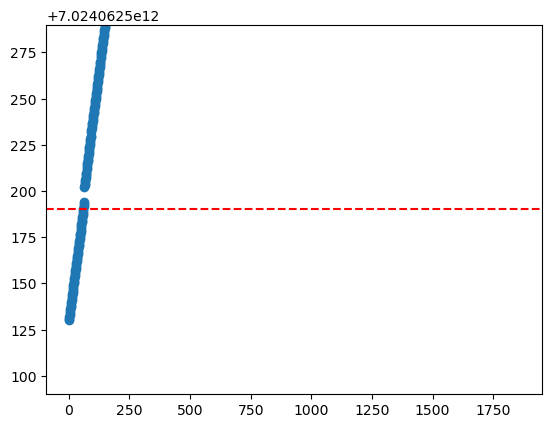

In [58]:
plt.scatter(np.arange(len(list_of_visits)), list_of_visits)
plt.axhline(src_for_single_obj.loc[select_single,'visit'].values[0], color='r', linestyle='--')  
plt.ylim(src_for_single_obj.loc[select_single,'visit'].values[0] - 100 , src_for_single_obj.loc[select_single,'visit'].values[0] + 100)

In [59]:
# position of the source
center = lsst.geom.SpherePoint(src_for_single_obj.loc[select_single,'ra'], src_for_single_obj.loc[select_single,'dec'] , lsst.geom.degrees)
center

SpherePoint(216.16532087735004*degrees, -12.71539803680108*degrees)

In [60]:
extent = lsst.geom.Extent2I(200, 200)
data1= {'detector': src_for_single_obj.loc[select_single,'detector'].values[0], 'visit': src_for_single_obj.loc[select_single,'visit'].values[0]}

src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)

one_pp_science = pp_butler.get('initial_pvi', dataId=data1)
one_pp_template = pp_butler.get('goodSeeingDiff_templateExp', dataId=data1)
one_pp_diffim = pp_butler.get('goodSeeingDiff_differenceExp', dataId=data1)

science_cutout = one_pp_science.getCutout(center, extent)
template_cutout = one_pp_template.getCutout(center, extent)
difference_cutout = one_pp_diffim.getCutout(center, extent)

In [61]:
# check that source is there via butler
src_for_single_obj_via_butler = src_via_butler[src_via_butler['diaObjectId'] == src_for_single_obj['diaObjectId'].values[0]]
src_for_single_obj_via_butler

diaSourceId  \
diaObjectId         band diaSourceId                                
3068394109518479458 i    3068394109518479458  3068394109518479458   

                                                      visit  detector  \
diaObjectId         band diaSourceId                                    
3068394109518479458 i    3068394109518479458  7024062500190         3   

                                                      diaObjectId  ssObjectId  \
diaObjectId         band diaSourceId                                            
3068394109518479458 i    3068394109518479458  3068394109518479458           0   

                                              parentDiaSourceId  \
diaObjectId         band diaSourceId                              
3068394109518479458 i    3068394109518479458                  0   

                                             ssObjectReassocTime  \
diaObjectId         band diaSourceId                               
3068394109518479458 i    3068394109518479458                 NaT   

                                              midpointMjdTai          ra  \
diaObjectId         band diaSourceId                                       
3068394109518479458 i    3068394109518479458     60487.08931  216.165321   

                                                 raErr  ...  \
diaObjectId         band diaSourceId                    ...   
3068394109518479458 i    3068394109518479458  0.000008  ...   

                                              pixelFlags_saturatedCenter  \
diaObjectId         band diaSourceId                                       
3068394109518479458 i    3068394109518479458                       False   

                                              pixelFlags_suspect  \
diaObjectId         band diaSourceId                               
3068394109518479458 i    3068394109518479458               False   

                                              pixelFlags_suspectCenter  \
diaObjectId         band diaSourceId                                     
3068394109518479458 i    3068394109518479458                     False   

                                              pixelFlags_streak  \
diaObjectId         band diaSourceId                              
3068394109518479458 i    3068394109518479458              False   

                                              pixelFlags_streakCenter  \
diaObjectId         band diaSourceId                                    
3068394109518479458 i    3068394109518479458                    False   

                                              pixelFlags_injected  \
diaObjectId         band diaSourceId                                
3068394109518479458 i    3068394109518479458                False   

                                              pixelFlags_injectedCenter  \
diaObjectId         band diaSourceId                                      
3068394109518479458 i    3068394109518479458                      False   

                                              pixelFlags_injected_template  \
diaObjectId         band diaSourceId                                         
3068394109518479458 i    3068394109518479458                         False   

                                              pixelFlags_injected_templateCenter  \
diaObjectId         band diaSourceId                                               
3068394109518479458 i    3068394109518479458                               False   

                                              programId  
diaObjectId         band diaSourceId                     
3068394109518479458 i    3068394109518479458          0  

[1 rows x 144 columns]

In [62]:
src_for_single_obj[src_for_single_obj['visit'] == src_for_single_obj_via_butler['visit'].values[0]]

diaSourceId          diaObjectId          ra        dec  \
152  3068394109518479458  3068394109518479458  216.165321 -12.715398   

        raErr   decErr  midpointMjdTai      psfFlux  psfFluxErr  scienceFlux  \
152  0.000008  0.00001     60487.08931  4106.269531  348.134827  98635.84375   

     ...  pixelFlags_saturatedCenter  pixelFlags_suspect  \
152  ...                       False               False   

    pixelFlags_suspectCenter  pixelFlags_streak  pixelFlags_streakCenter  \
152                    False              False                    False   

     pixelFlags_injected  pixelFlags_injectedCenter  \
152                False                      False   

     pixelFlags_injected_template  pixelFlags_injected_templateCenter  \
152                         False                               False   

    reliability  
152        None  

[1 rows x 55 columns]

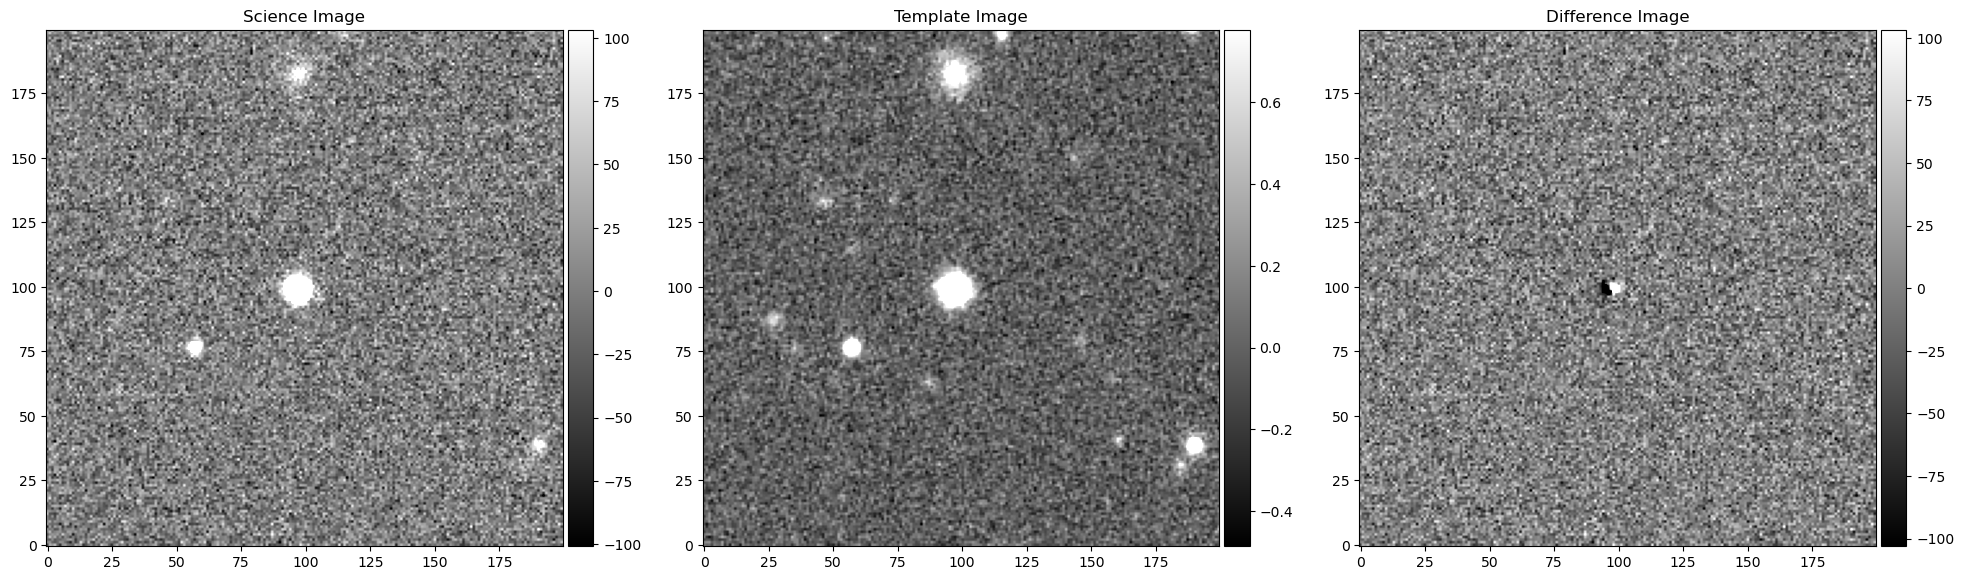

In [63]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_cutout.image.array, interval=ZScaleInterval())
norm_template = ImageNormalize(template_cutout.image.array, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(science_cutout.image.array, origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(template_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(difference_cutout.image.array, origin='lower', norm=norm_diffim, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')

# Show the plot
plt.show()


Text(0.5, 1.0, 'Difference Image')

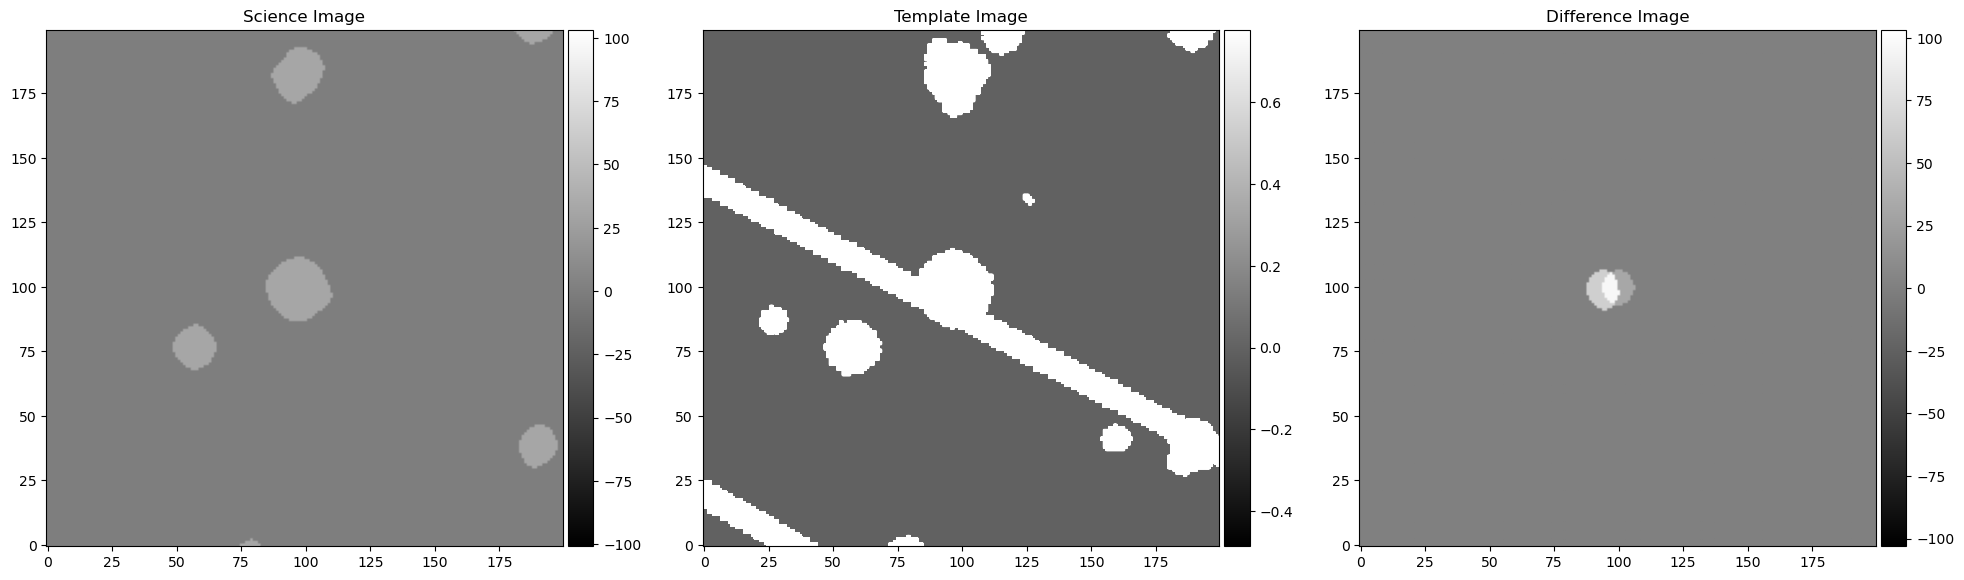

In [64]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_cutout.image.array, interval=ZScaleInterval())
norm_template = ImageNormalize(template_cutout.image.array, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(science_cutout.mask.array, origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(template_cutout.mask.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(difference_cutout.mask.array, origin='lower', norm=norm_diffim, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')


In [65]:
template_cutout.mask.getMaskPlaneDict().items()

dict_items([('BAD', 0), ('CLIPPED', 9), ('CR', 3), ('DETECTED', 5), ('DETECTED_NEGATIVE', 6), ('EDGE', 4), ('INEXACT_PSF', 10), ('INJECTED', 11), ('INJECTED_TEMPLATE', 12), ('INTRP', 2), ('NOT_DEBLENDED', 13), ('NO_DATA', 8), ('REJECTED', 14), ('SAT', 1), ('SAT_TEMPLATE', 15), ('SENSOR_EDGE', 16), ('STREAK', 17), ('SUSPECT', 7), ('UNMASKEDNAN', 18)])

In [66]:
print(np.unique(template_cutout.mask.array))
print(np.unique(difference_cutout.mask.array))
print(np.unique(science_cutout.mask.array))

[    0    12    32 66560 66592]
[ 0 32 64 96]
[ 0 32]


In [67]:
def plotFlagImages(exp, flagList=['DETECTED_NEGATIVE', 'DETECTED', 'SENSOR_EDGE', 'INEXACT_PSF']):
    fig = plt.figure(figsize=(24,8))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im

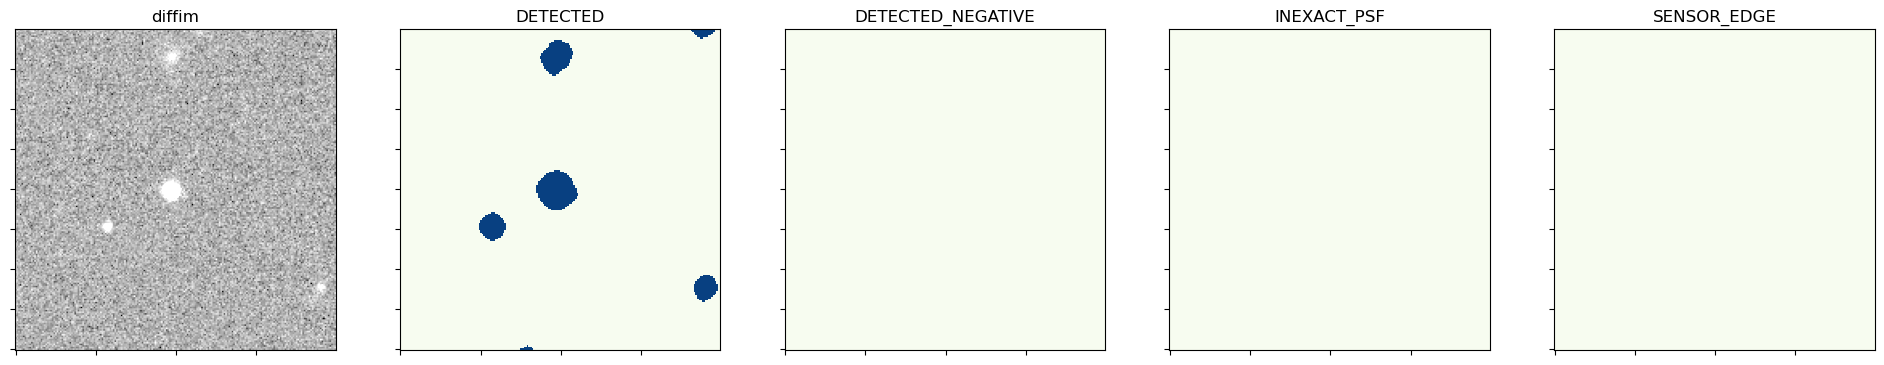

In [68]:
plotFlagImages(science_cutout)

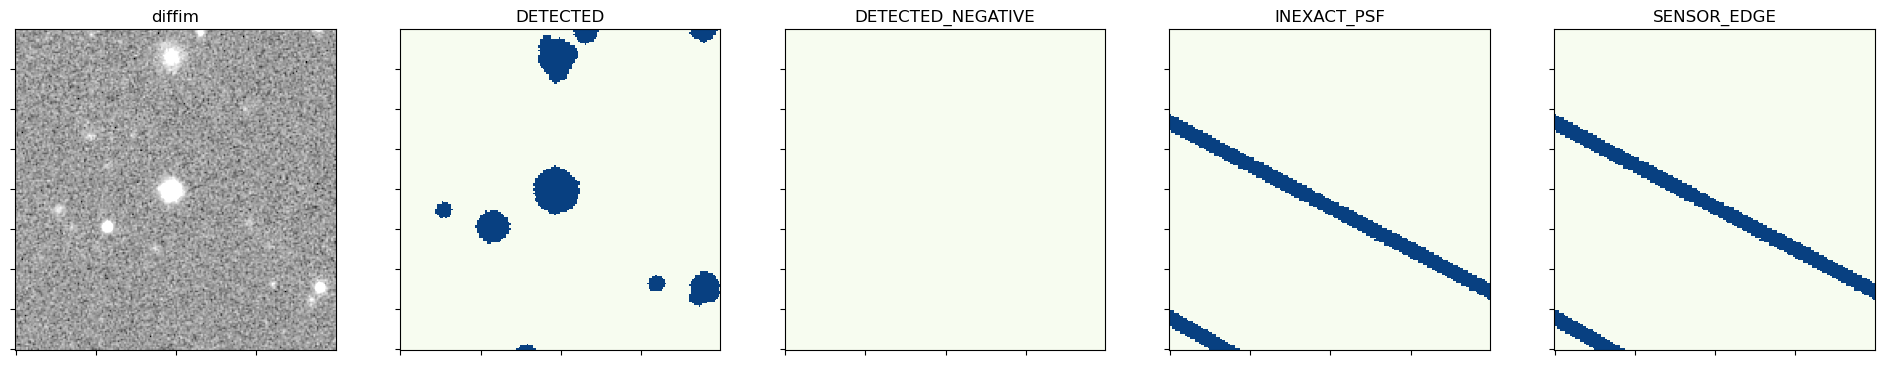

In [69]:
plotFlagImages(template_cutout)

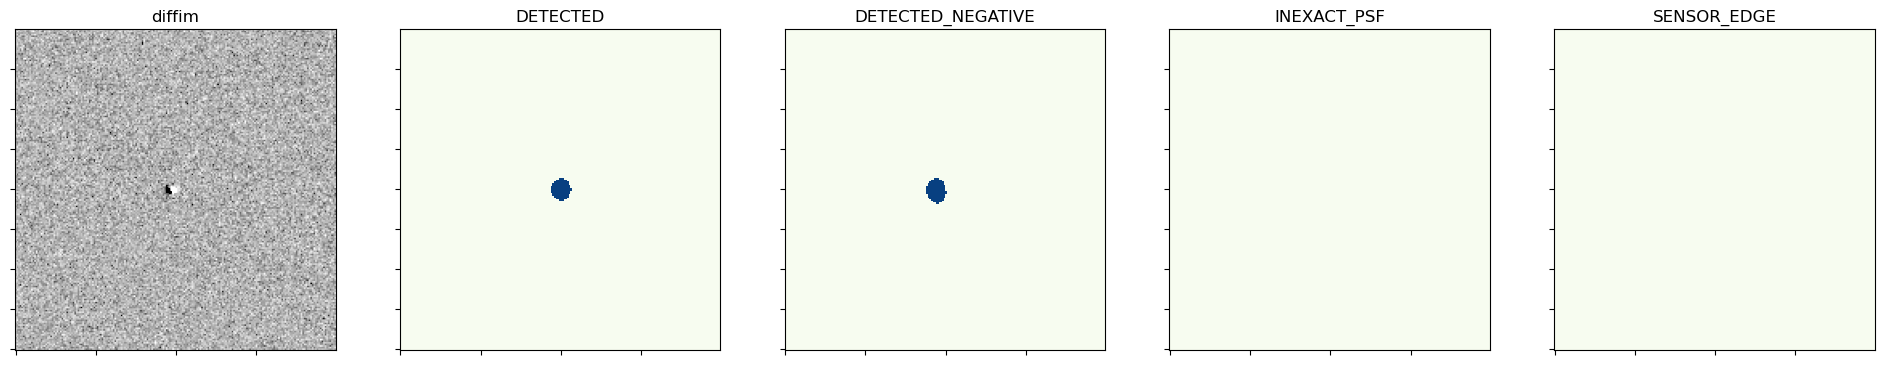

In [70]:
plotFlagImages(difference_cutout)

In [71]:
single_obj = obj4_field_nan[obj4_field_nan['nDiaSources'] > 10].iloc[230]
single_obj

diaObjectId                       3068394111678546018
validityStart               2024-06-26 02:55:53+00:00
validityEnd                                      None
ra                                         216.280468
raErr                                             NaN
                                      ...            
y_psfFluxLinearIntercept                         None
y_psfFluxMaxSlope                                None
y_psfFluxErrMean                                 None
lastNonForcedSource         2024-06-26 02:53:01+00:00
nDiaSources                                        28
Name: 155859, Length: 190, dtype: object

In [72]:
single_obj = obj4_field_not_nan[obj4_field_not_nan['nDiaSources'] > 10].iloc[230]
single_obj

diaObjectId                       3068394109518479458
validityStart               2024-06-26 02:56:11+00:00
validityEnd                                      None
ra                                         216.165437
raErr                                        0.000008
                                      ...            
y_psfFluxLinearIntercept                         None
y_psfFluxMaxSlope                                None
y_psfFluxErrMean                                 None
lastNonForcedSource         2024-06-26 02:55:46+00:00
nDiaSources                                        19
Name: 154061, Length: 190, dtype: object

In [73]:
# select all sources for this object
src_for_single_obj = src4_field[(src4_field['diaObjectId']==single_obj['diaObjectId']) ]
src_for_single_obj[['centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

centroid_flag  apFlux_flag  psfFlux_flag  forced_PsfFlux_flag  \
152            False        False         False                False   
1448           False        False         False                False   
10758           True         True          True                 True   
21982           True         True          True                 True   
25305           True         True          True                 True   
27819          False        False         False                False   
29637          False        False         False                False   
33789          False        False         False                False   
35253          False        False         False                False   
36094          False        False         False                False   
38357          False        False         False                False   
39371          False        False         False                False   
45887           True         True          True                 True   
47081          False        False         False                False   
48372          False        False         False                False   
50239          False        False         False                False   
51739          False        False         False                False   
53329           True         True          True                 True   
57244          False        False         False                False   

       shape_flag  
152          True  
1448        False  
10758        True  
21982        True  
25305        True  
27819       False  
29637        True  
33789       False  
35253        True  
36094       False  
38357        True  
39371        True  
45887        True  
47081        True  
48372       False  
50239        True  
51739        True  
53329        True  
57244        True

In [74]:
src_for_single_obj.loc[45887]

diaSourceId                                 3068394170709180481
diaObjectId                                 3068394109518479458
ra                                                   216.165468
dec                                                  -12.715666
raErr                                                       NaN
decErr                                                      NaN
midpointMjdTai                                      60487.11877
psfFlux                                            -1608.145874
psfFluxErr                                           303.842804
scienceFlux                                        61105.542969
scienceFluxErr                                       296.876678
snr                                                    5.301852
band                                                          r
visit                                             7024062500247
detector                                                      0
x                                       

In [75]:
src_for_single_obj[['diaSourceId', 'raErr', 'decErr', 'xErr', 'yErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

diaSourceId     raErr    decErr      xErr      yErr  \
152    3068394109518479458  0.000008  0.000010       NaN       NaN   
1448   3068394111653380230  0.000010  0.000012  0.175130  0.211453   
10758  3068394133144993855       NaN       NaN       NaN       NaN   
21982  3068394146017312928       NaN       NaN       NaN       NaN   
25305  3068394150308085797       NaN       NaN       NaN       NaN   
27819  3068394152459763779  0.000022  0.000029  0.381295  0.539300   
29637  3068394155676794899  0.000016  0.000022       NaN       NaN   
33789  3068394159971762331  0.000010  0.000009       NaN       NaN   
35253  3068394161058086982  0.000017  0.000015       NaN       NaN   
36094  3068394162119245909  0.000015  0.000015  0.278583  0.272957   
38357  3068394163205570632  0.000022  0.000014  0.411763  0.245570   
39371  3068394164279312397  0.000007  0.000006       NaN       NaN   
45887  3068394170709180481       NaN       NaN       NaN       NaN   
47081  3068394171787116674  0.000009  0.000008       NaN       NaN   
48372  3068394172856664167  0.000027  0.000028  0.503825  0.500539   
50239  3068394127759507529  0.000017  0.000015  0.305494  0.271959   
51739  3068394128833249386  0.000012  0.000014  0.226048  0.243815   
53329  3068394129906991231       NaN       NaN       NaN       NaN   
57244  3068394126685765704  0.000022  0.000020  0.413977  0.364219   

           psfFlux band  centroid_flag  apFlux_flag  psfFlux_flag  \
152    4106.269531    i          False        False         False   
1448   4028.226074    i          False        False         False   
10758 -1692.929199    g           True         True          True   
21982 -1451.361938    g           True         True          True   
25305 -2636.998779    g           True         True          True   
27819  1860.563477    r          False        False         False   
29637  2031.590576    r          False        False         False   
33789  4334.764160    r          False        False         False   
35253  1988.346924    r          False        False         False   
36094  2384.051270    r          False        False         False   
38357  1970.999268    r          False        False         False   
39371  5208.815430    r          False        False         False   
45887 -1608.145874    r           True         True          True   
47081  5071.286133    r          False        False         False   
48372  1921.567383    r          False        False         False   
50239  2690.723145    i          False        False         False   
51739  3265.170654    i          False        False         False   
53329 -1861.365845    i           True         True          True   
57244  2531.459717    i          False        False         False   

       forced_PsfFlux_flag  shape_flag  
152                  False        True  
1448                 False       False  
10758                 True        True  
21982                 True        True  
25305                 True        True  
27819                False       False  
29637                False        True  
33789                False       False  
35253                False        True  
36094                False       False  
38357                False        True  
39371                False        True  
45887                 True        True  
47081                False        True  
48372                False       False  
50239                False        True  
51739                False        True  
53329                 True        True  
57244                False        True

In [ ]:
# If xErr and yErr are NaN, raErr and decErr are not NaN if isDipole is True
# If xErr and yErr are NaN, raErr and decErr are NaN if isDipole is False

In [90]:
src_for_single_obj_via_butler

diaSourceId  \
diaObjectId         band diaSourceId                                
3068394109518479458 i    3068394109518479458  3068394109518479458   

                                                      visit  detector  \
diaObjectId         band diaSourceId                                    
3068394109518479458 i    3068394109518479458  7024062500190         3   

                                                      diaObjectId  ssObjectId  \
diaObjectId         band diaSourceId                                            
3068394109518479458 i    3068394109518479458  3068394109518479458           0   

                                              parentDiaSourceId  \
diaObjectId         band diaSourceId                              
3068394109518479458 i    3068394109518479458                  0   

                                             ssObjectReassocTime  \
diaObjectId         band diaSourceId                               
3068394109518479458 i    3068394109518479458                 NaT   

                                              midpointMjdTai          ra  \
diaObjectId         band diaSourceId                                       
3068394109518479458 i    3068394109518479458     60487.08931  216.165321   

                                                 raErr  ...  \
diaObjectId         band diaSourceId                    ...   
3068394109518479458 i    3068394109518479458  0.000008  ...   

                                              pixelFlags_saturatedCenter  \
diaObjectId         band diaSourceId                                       
3068394109518479458 i    3068394109518479458                       False   

                                              pixelFlags_suspect  \
diaObjectId         band diaSourceId                               
3068394109518479458 i    3068394109518479458               False   

                                              pixelFlags_suspectCenter  \
diaObjectId         band diaSourceId                                     
3068394109518479458 i    3068394109518479458                     False   

                                              pixelFlags_streak  \
diaObjectId         band diaSourceId                              
3068394109518479458 i    3068394109518479458              False   

                                              pixelFlags_streakCenter  \
diaObjectId         band diaSourceId                                    
3068394109518479458 i    3068394109518479458                    False   

                                              pixelFlags_injected  \
diaObjectId         band diaSourceId                                
3068394109518479458 i    3068394109518479458                False   

                                              pixelFlags_injectedCenter  \
diaObjectId         band diaSourceId                                      
3068394109518479458 i    3068394109518479458                      False   

                                              pixelFlags_injected_template  \
diaObjectId         band diaSourceId                                         
3068394109518479458 i    3068394109518479458                         False   

                                              pixelFlags_injected_templateCenter  \
diaObjectId         band diaSourceId                                               
3068394109518479458 i    3068394109518479458                               False   

                                              programId  
diaObjectId         band diaSourceId                     
3068394109518479458 i    3068394109518479458          0  

[1 rows x 144 columns]

In [95]:
# find this source in the butler, but as a candidate and associate it with the source

data1= {'detector': 3, 'visit': 7024062500190}
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)

single_butler_src = src_via_butler[src_via_butler['diaSourceId'] == 3068394109518479458]
single_butler_cand_src = src_cand_via_butler[src_cand_via_butler['id'] == 3068394109518479458]

In [102]:
single_butler_src

diaSourceId  \
diaObjectId         band diaSourceId                                
3068394109518479458 i    3068394109518479458  3068394109518479458   

                                                      visit  detector  \
diaObjectId         band diaSourceId                                    
3068394109518479458 i    3068394109518479458  7024062500190         3   

                                                      diaObjectId  ssObjectId  \
diaObjectId         band diaSourceId                                            
3068394109518479458 i    3068394109518479458  3068394109518479458           0   

                                              parentDiaSourceId  \
diaObjectId         band diaSourceId                              
3068394109518479458 i    3068394109518479458                  0   

                                             ssObjectReassocTime  \
diaObjectId         band diaSourceId                               
3068394109518479458 i    3068394109518479458                 NaT   

                                              midpointMjdTai          ra  \
diaObjectId         band diaSourceId                                       
3068394109518479458 i    3068394109518479458     60487.08931  216.165321   

                                                 raErr  ...  \
diaObjectId         band diaSourceId                    ...   
3068394109518479458 i    3068394109518479458  0.000008  ...   

                                              pixelFlags_saturatedCenter  \
diaObjectId         band diaSourceId                                       
3068394109518479458 i    3068394109518479458                       False   

                                              pixelFlags_suspect  \
diaObjectId         band diaSourceId                               
3068394109518479458 i    3068394109518479458               False   

                                              pixelFlags_suspectCenter  \
diaObjectId         band diaSourceId                                     
3068394109518479458 i    3068394109518479458                     False   

                                              pixelFlags_streak  \
diaObjectId         band diaSourceId                              
3068394109518479458 i    3068394109518479458              False   

                                              pixelFlags_streakCenter  \
diaObjectId         band diaSourceId                                    
3068394109518479458 i    3068394109518479458                    False   

                                              pixelFlags_injected  \
diaObjectId         band diaSourceId                                
3068394109518479458 i    3068394109518479458                False   

                                              pixelFlags_injectedCenter  \
diaObjectId         band diaSourceId                                      
3068394109518479458 i    3068394109518479458                      False   

                                              pixelFlags_injected_template  \
diaObjectId         band diaSourceId                                         
3068394109518479458 i    3068394109518479458                         False   

                                              pixelFlags_injected_templateCenter  \
diaObjectId         band diaSourceId                                               
3068394109518479458 i    3068394109518479458                               False   

                                              programId  
diaObjectId         band diaSourceId                     
3068394109518479458 i    3068394109518479458          0  

[1 rows x 144 columns]

In [118]:
single_butler_src[['diaSourceId', 'ra', 'raErr', 'dec', 'decErr', 'x', 'xErr', 'y', 'yErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

diaSourceId          ra  \
diaObjectId         band diaSourceId                                            
3068394109518479458 i    3068394109518479458  3068394109518479458  216.165321   

                                                 raErr        dec   decErr  \
diaObjectId         band diaSourceId                                         
3068394109518479458 i    3068394109518479458  0.000008 -12.715398  0.00001   

                                                       x  xErr            y  \
diaObjectId         band diaSourceId                                          
3068394109518479458 i    3068394109518479458  431.811554   NaN  1537.749512   

                                              yErr      psfFlux band  \
diaObjectId         band diaSourceId                                   
3068394109518479458 i    3068394109518479458   NaN  4106.269531    i   

                                              centroid_flag  apFlux_flag  \
diaObjectId         band diaSourceId                                       
3068394109518479458 i    3068394109518479458          False        False   

                                              psfFlux_flag  \
diaObjectId         band diaSourceId                         
3068394109518479458 i    3068394109518479458         False   

                                              forced_PsfFlux_flag  shape_flag  
diaObjectId         band diaSourceId                                           
3068394109518479458 i    3068394109518479458                False        True

In [125]:
catalog = single_butler_cand_src
columns = catalog.schema.getNames()  # Get all column names
data = {col: catalog[col].tolist() for col in columns}  # Extract each column's data

# Create a pandas DataFrame
df = pd.DataFrame(data)

df[['id', 'coord_ra', 'coord_raErr', 'coord_dec', 'coord_decErr', 'base_SdssCentroid_x', 'base_SdssCentroid_xErr', 'base_SdssCentroid_y', 'base_SdssCentroid_yErr', 'base_PsfFlux_instFlux']]

id  srcMatchId  coord_ra   coord_raErr  coord_dec  \
0  3068394109518479458           0  3.772797  1.309876e-07  -0.221926   

   coord_decErr  base_SdssCentroid_x  base_SdssCentroid_xErr  \
0  1.661769e-07           434.075123                0.133803   

   base_SdssCentroid_y  base_SdssCentroid_yErr  base_PsfFlux_instFlux  
0          1538.242949                0.174691            4106.269749

In [123]:
radians_to_degrees(3.772797)

216.16534505961846

In [112]:
columns

{'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_instFlux',
 'base_CircularApertureFlux_12_0_instFluxErr',
 'base_InvalidPsf_flag',
 'base_LocalPhotoCalib',
 'base_LocalPhotoCalibErr',
 'base_LocalPhotoCalib_flag',
 'base_LocalWcs_CDMatrix_1_1',
 'base_LocalWcs_CDMatrix_1_2',
 'base_LocalWcs_CDMatrix_2_1',
 'base_LocalWcs_CDMatrix_2_2',
 'base_LocalWcs_flag',
 'base_PixelFlags_flag',
 'base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_badCenter',
 'base_PixelFlags_flag_badCenterAll',
 'base_PixelFlags_flag_cr',
 'base_PixelFlags_flag_crCenter',
 'base_PixelFlags_flag_crCenterAll',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_edgeCenter',
 'base_PixelFlags_flag_edgeCenterAll',
 'base_PixelFlags_flag_injected',
 'base_PixelFlags_flag_injectedCenter',
 'base_PixelFlags_flag_injectedCenterAll',
 'base_PixelFlags_flag_injected_template',
 'base_PixelFlags_flag_injected_templateCenter',
 'base_PixelFlag

In [101]:
single_butler_cand_src.

<class 'lsst.afw.table.SourceCatalog'>
         id              coord_ra      ... srcMatchId sky_source
                           rad         ...                      
------------------- ------------------ ... ---------- ----------
3068394109518479458 3.7727965779397956 ...          0      False

In [93]:
src_cand_via_butler

<class 'lsst.afw.table.SourceCatalog'>
         id              coord_ra      ... srcMatchId sky_source
                           rad         ...                      
------------------- ------------------ ... ---------- ----------
3068394109518479361  3.770136114820828 ...          0      False
3068394109518479362 3.7702406764573064 ...          0      False
3068394109518479363 3.7702191135069847 ...          0      False
3068394109518479364   3.77100648008478 ...          0      False
3068394109518479365 3.7726778283477884 ...          0      False
3068394109518479366 3.7700050867928567 ...          0      False
3068394109518479367 3.7702560169191672 ...          0      False
3068394109518479368  3.771891431711748 ...          0      False
3068394109518479369   3.77145643633392 ...          0      False
                ...                ... ...        ...        ...
3068394109518479612 3.7726234350409373 ...          0      False
3068394109518479613 3.7735290304142652 ...         

## Statistical analysis

In [76]:
list(obj4_field_nan.columns)

['diaObjectId',
 'validityStart',
 'validityEnd',
 'ra',
 'raErr',
 'dec',
 'decErr',
 'ra_dec_Cov',
 'radecMjdTai',
 'pmRa',
 'pmRaErr',
 'pmDec',
 'pmDecErr',
 'parallax',
 'parallaxErr',
 'pmRa_pmDec_Cov',
 'pmRa_parallax_Cov',
 'pmDec_parallax_Cov',
 'pmParallaxLnL',
 'pmParallaxChi2',
 'pmParallaxNdata',
 'u_psfFluxMean',
 'u_psfFluxMeanErr',
 'u_psfFluxSigma',
 'u_psfFluxChi2',
 'u_psfFluxNdata',
 'u_fpFluxMean',
 'u_fpFluxMeanErr',
 'u_fpFluxSigma',
 'g_psfFluxMean',
 'g_psfFluxMeanErr',
 'g_psfFluxSigma',
 'g_psfFluxChi2',
 'g_psfFluxNdata',
 'g_fpFluxMean',
 'g_fpFluxMeanErr',
 'g_fpFluxSigma',
 'r_psfFluxMean',
 'r_psfFluxMeanErr',
 'r_psfFluxSigma',
 'r_psfFluxChi2',
 'r_psfFluxNdata',
 'r_fpFluxMean',
 'r_fpFluxMeanErr',
 'r_fpFluxSigma',
 'i_psfFluxMean',
 'i_psfFluxMeanErr',
 'i_psfFluxSigma',
 'i_psfFluxChi2',
 'i_psfFluxNdata',
 'i_fpFluxMean',
 'i_fpFluxMeanErr',
 'i_fpFluxSigma',
 'z_psfFluxMean',
 'z_psfFluxMeanErr',
 'z_psfFluxSigma',
 'z_psfFluxChi2',
 'z_psfFluxNd

(-10000.0, 10000.0)

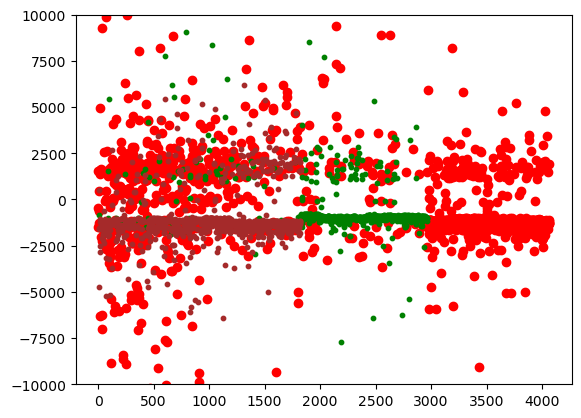

In [77]:
obj4_field_nan_min_max = obj4_field_nan[['diaObjectId','g_psfFluxMean', 'g_psfFluxMin', 'g_psfFluxMax', 'r_psfFluxMean', 'r_psfFluxMin', 'r_psfFluxMax', 'i_psfFluxMean', 'i_psfFluxMin', 'i_psfFluxMax']]

plt.scatter(np.arange(len(obj4_field_nan_min_max)), obj4_field_nan_min_max['r_psfFluxMean'].values, color='red')
plt.scatter(np.arange(len(obj4_field_nan_min_max)), obj4_field_nan_min_max['g_psfFluxMean'].values, s=10, color='g')
plt.scatter(np.arange(len(obj4_field_nan_min_max)), obj4_field_nan_min_max['i_psfFluxMean'].values, s=10, color='brown')
plt.ylim(-10000, 10000)

In [78]:
obj4_field_nan_min_max[obj4_field_nan_min_max['r_psfFluxMean']>1000]

diaObjectId  g_psfFluxMean  g_psfFluxMin  g_psfFluxMax  \
153210  3068394109505896606            NaN           NaN           NaN   
153293  3068394109505896700            NaN           NaN           NaN   
153298  3068394109505896705            NaN           NaN           NaN   
153313  3068394109505896723            NaN           NaN           NaN   
153315  3068394109505896725            NaN           NaN           NaN   
...                     ...            ...           ...           ...   
171406  3068394172869247095            NaN           NaN           NaN   
171432  3068394172881829904            NaN           NaN           NaN   
171439  3068394172881829934            NaN           NaN           NaN   
171444  3068394172881829955            NaN           NaN           NaN   
171470  3068394172886024343            NaN           NaN           NaN   

        r_psfFluxMean  r_psfFluxMin  r_psfFluxMax  i_psfFluxMean  \
153210    1518.954346   1518.954346   1518.954346            NaN   
153293    1437.075562   1437.075562   1437.075562            NaN   
153298    4969.968262   3656.614990   9012.880859            NaN   
153313    1355.668823   1355.668823   1355.668823            NaN   
153315    1581.683838   1581.683838   1581.683838            NaN   
...               ...           ...           ...            ...   
171406    1629.364624   1629.364624   1629.364624            NaN   
171432    1935.905151   1935.905029   1935.905029            NaN   
171439    3431.348633   3431.348877   3431.348877            NaN   
171444    1486.537964   1486.538086   1486.538086            NaN   
171470    1919.322876   1919.322754   1919.322754            NaN   

        i_psfFluxMin  i_psfFluxMax  
153210           NaN           NaN  
153293           NaN           NaN  
153298           NaN           NaN  
153313           NaN           NaN  
153315           NaN           NaN  
...              ...           ...  
171406           NaN           NaN  
171432           NaN           NaN  
171439           NaN           NaN  
171444           NaN           NaN  
171470           NaN           NaN  

[441 rows x 10 columns]

In [79]:
src4_field[['diaSourceId', 'raErr', 'decErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

diaSourceId     raErr    decErr       psfFlux band  \
0      3068394109514285084       NaN       NaN  -1946.655640    i   
1      3068394109514285091  0.000006  0.000005   9831.191406    i   
2      3068394109514285097  0.000005  0.000004  11874.484375    i   
3      3068394109514285112  0.000027  0.000021   1254.862061    i   
4      3068394109514285133  0.000016  0.000022   1797.926636    i   
...                    ...       ...       ...           ...  ...   
58246  3068394109510091044  0.000003  0.000003  26648.339844    i   
58247  3068394109510091045  0.000005  0.000004  10978.866211    i   
58248  3068394109510091046  0.000007  0.000008   3998.014160    i   
58249  3068394109510091047  0.000012  0.000013   2391.240234    i   
58250  3068394109510091048       NaN       NaN   2049.343994    i   

       centroid_flag  apFlux_flag  psfFlux_flag  forced_PsfFlux_flag  \
0               True         True          True                 True   
1              False        False         False                False   
2              False        False         False                False   
3              False        False         False                False   
4              False        False         False                False   
...              ...          ...           ...                  ...   
58246          False        False         False                False   
58247          False        False         False                False   
58248          False        False         False                False   
58249          False        False         False                False   
58250           True         True          True                 True   

       shape_flag  
0            True  
1            True  
2            True  
3           False  
4           False  
...           ...  
58246       False  
58247       False  
58248        True  
58249        True  
58250        True  

[58251 rows x 10 columns]

In [80]:
print(len(src4_field))

print(len(src4_field[ (src4_field['psfFlux']<0)]['raErr']))
print(len(src4_field[(src4_field['shape_flag']==True)]))
src_shape_negative = src4_field[(src4_field['shape_flag']==True) & (src4_field['psfFlux']<0)]['raErr']
print(len(src_shape_negative))
src_shape_negative[~np.isnan(src_shape_negative)].index
print(np.sum(np.isnan(src4_field['raErr'])))

58251
15782
29300
15778
16401


In [81]:
np.sum(np.isnan(src4_field['raErr']))

16401

In [82]:
src4_field[['diaSourceId', 'raErr', 'decErr', 'psfFlux', 'psfFluxErr', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']].loc[src_shape_negative[~np.isnan(src_shape_negative)].index]

diaSourceId     raErr    decErr      psfFlux  psfFluxErr band  \
1311   3068394109539451098  0.000366  0.000131 -1482.257935  233.992737    i   
2152   3068394111670157475  0.000027  0.000037   -92.264366  216.773254    i   
2311   3068394111674351700  0.000035  0.000073  -580.065918  232.914749    i   
3885   3068394112743899273  0.000238  0.000072  -640.667603  224.214325    i   
3903   3068394112743899298  0.000322  0.000090 -2063.958252  581.654968    i   
...                    ...       ...       ...          ...         ...  ...   
53355  3068394129906991262  0.000851  0.001028  -291.092712  814.717468    i   
54371  3068394123485511681  0.000076  0.000012 -1725.450439  374.449738    i   
55145  3068394124542476388  0.000091  0.000020   -37.486374  237.978043    i   
55606  3068394124571836466  0.000013  0.000029  -513.365417  264.827393    i   
57004  3068394125641384097  0.000008  0.000013 -1531.627319  235.394424    i   

       centroid_flag  apFlux_flag  psfFlux_flag  forced_PsfFlux_flag  \
1311            True         True          True                 True   
2152           False        False         False                False   
2311           False        False         False                False   
3885            True         True          True                 True   
3903           False         True          True                 True   
...              ...          ...           ...                  ...   
53355          False        False         False                False   
54371           True         True          True                 True   
55145          False        False         False                False   
55606          False        False         False                False   
57004           True         True          True                 True   

       shape_flag  
1311         True  
2152         True  
2311         True  
3885         True  
3903         True  
...           ...  
53355        True  
54371        True  
55145        True  
55606        True  
57004        True  

[64 rows x 11 columns]

In [83]:
src_shape_negative = src4_field[(src4_field['shape_flag']==True) & (src4_field['psfFlux']>0)]['raErr']
src_shape_negative[~np.isnan(src_shape_negative)]

1        0.000006
2        0.000005
6        0.000022
21       0.000013
22       0.000004
           ...   
58237    0.000011
58241    0.000010
58243    0.000004
58248    0.000007
58249    0.000012
Name: raErr, Length: 12835, dtype: float64

### Dinking with machine learning

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

In [85]:
data = src4_field[['raErr', 'psfFlux', 'psfFluxErr', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]
data = data.copy(deep=True)
# Step 1: Label 'raErr' where NaN is 1, non-NaN is 0
data['raErr_is_nan'] = data['raErr'].isna().astype(int)

# Drop 'raErr' since it's our target
X = data.drop(columns=['raErr', 'raErr_is_nan'])
y = data['raErr_is_nan']

# Step 2: Normalize the features (Optional for categorical features like 'band')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 6: Analyze feature importance using model coefficients
# The higher the absolute value of the coefficient, the more important the feature.
feature_importance = pd.Series(model.coef_[0], index=data.columns[:-1])
print("\nFeature Importance based on Logistic Regression Coefficients:")
print(feature_importance)

# Step 7: (Optional) Use permutation importance for better interpretability
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Display the feature importance from permutation importance
print("\nPermutation Importance:")
for i in np.argsort(perm_importance.importances_mean)[::-1]:
    print(f"Feature {X.columns[i]} Importance: {perm_importance.importances_mean[i]:.4f}")

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [177]:
src4_field['raErr', 'psfFlux', 'psfFluxErr', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']

KeyError: ('raErr', 'psfFlux', 'psfFluxErr', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag')

In [184]:
np.sum(np.isnan(data['psfFlux']))

38